Sentimental Analysis of Ride-Based Reddit Reviews for Universal Orlando Resort and Walt Disney World

Walt Disney once said, "If you can dream it, you can do it." For over 100 years, Disney has been one of the most prominent leaders in the entertainment industry. Since 1923, as a studio, they captures the hearts of millions with forefront animation technology and innovation, but have quickly grown to include not just visual entertainment but themed attractions in person. From 1971 onwards, Disney World has by and large been the physical interface, synonymous with the studio. Yet, as the 90's arrived, new market arrivals in the form of Universal Studios and smaller themed parks sought to disrupt the market and claim their share of enetertainment-based tourism. As quite possibly the two largest rivals in the entertainment industry, Disney and Universal have gone back adn forth challenging each other's domain of itellectual property, creativity, and audience market share from film productions to streamed entertainment, all the way down to physical media, and merchandise. This back and forth relationship makes for great content not only for lovers of the entertainment industry but theme park enthusiasts who often bicker between who the superior power is. 

One such place to analyze said conversations are formal public forum spaces, especially ones held online where users can talk about their experiences to each vacation destination. A popular online public forum most are familiar with is known as Reddit. Since 2005, Reddit has provided users with the opportunity to explore, explain, and share their passions with each other in communities known as subreddits. These subreddits allow users the opportunity to title posts, push out various forms of content, and then interact with other users in the comments section where they discuss topics pertaining to the main posts. It is in these subreddits that the basis for analyzing the relationship between Universal Studios and Disney can be observed (under the subreddits of r/UniversalOrlando and r/WaltDisneyWorld respectively). Within each of these communities one can click into new posts and obtain information regarding anythign from upcoming rides, to industry news all the way down to intimate details of other's experiences at said resorts. It makes for a great place to scrape unstructured text data and derive meaningful information out of the content others leave behind.

The goal of this reserch project is to see whether one can accurately scrape Reddit posts from both Universal Orlando and Walt Disney world and then analyze reviews/posts via sentiment analysis to ulitmately see if there is a difference(s) between each resort, parks within each resort, and the unique ride types of rides for each theme park. Thus, one after the end of this project will subsequently be able to model relationships between how consumers feel about varying levels of each Resort's operations from a system-wide level down to a ride-by-ride approach. 

To scrape Reddit, one must first obtain a Reddit developer key(https://www.reddit.com/prefs/apps) and sign up with their associated API wrapper in python known as PRAW (https://praw.readthedocs.io/en/stable/). Please note that as of 2023, Pushshift, an alternate python wrapper that allowed users to scrape data from Reddit past PRAW's historical limits, has now been officially banned, and cannot be used for the context of this analysis. With that said, this analysis will take place under the notion that PRAW is limited to the latest 1000 posts within each subreddit, and as such subsamples collected fromw within my lack historical context and deep learning capabilities. Going forward if one wanted to amasss raw text collected from larger populations than these limits, they would need to pull in data from multiple subreddits associated with their over-arching topics (such as r/Disney, r/DisneyWorld, r/Disneyland and r/Universal, r/UniversalStudios etc...). For the basis of this analysis, two subreddits will be sufficient enough to explore elementary themes such as resort/park and ride-type/ride comparative analysis.

To start we need to install and import any libraries that are needed for the subsequent scraping and analysis (Here praw, nltk, bertopic, transformers, torch, and some more basic packages were brought into the system)

In [217]:

##Import Libraries
from tqdm import tqdm #instead of print outs for relevant posts found this gives us a progress bar to track
import praw #The reddit api
import re #for regex
import random #for our random sleep intervals in between pulls
import time #also for the sleep intervals
import pandas as pd #to create dataframes
import ollama #for deep seek analysis
import numpy as np #math
import matplotlib.pyplot as plt #Plotting
import seaborn as sns #Plotting
import plotly.express as px #For tree maps
from transformers import pipeline #for sentiment analysis
import torch #sentiment/topic analysis
from bertopic import BERTopic #for sentiment analysis
from bertopic.vectorizers import ClassTfidfTransformer #for topic analysis
from joblib import load, dump #if we cant to use multiple jobs
import nltk #to pull stop words
import pprint as pprint #to print
from nltk.tokenize import word_tokenize #to tokenize
from nltk.stem import WordNetLemmatizer #to lematize
from nltk.corpus import stopwords, wordnet #to pull stop words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer #topic analysis
from sklearn.decomposition import LatentDirichletAllocation, NMF #topic analysis
import os #for env cred files
from dotenv import load_dotenv #loading env cred files

Next you can also set up a DeepSeek model(https://ollama.com/library/deepseek-r1) to help analyze the raw text submitted by users and return associated ride/ride names.

In [219]:
# DeepSeek setup
model_name = "deepseek-r1:14b"

#This is the function I created in connection with deep think to construct a query to analyze a post/self title's text and return the ride associated with said text.
def deepseek_analyze(text, index):
    response = ollama.chat(model=model_name, messages=[
        {"role": "user", "content": f"""Identify and return only Universal Orlando ride names found in the following text.
Return them as a plain list with one ride per line and no additional explanation. Do not include any words other than the ride names.
Text: {text}"""}
    ])
    
    
    rides = response['message']['content'].strip().split("\n")
    
    #Remove how DeepThink analyzes from the answer
    rides = [ride.strip() for ride in rides if ride.strip() and not any(tag in ride.lower() for tag in ["think", "so", "i believe", "as for", "now", "let me"])]

    #Create a progress bar for how many rides/Posts DT has processed 
    if index % 10 == 0:
        print(f"Processed {index} rows...")
        
    return rides

Then comes setting up PRAW itself. You need to enter in the client id, secret and you personal password/username that you use for Reddit alongside some standard headers.

In [221]:
print([f for f in os.listdir() if f.endswith(".env")])

['.env']


In [223]:
print("System USERNAME:", os.getenv("USERNAME"))

System USERNAME: lotrc


I have another .env file running not in this wd but somehow my username from that one is overriding the .env username I created for this (To store credentials away from my actual script). As such I had to re-write this new .env file to create a different username object to store my Reddit username just so it wouldn't refer back to the system username on my pc which was the default

In [ ]:
reddit = praw.Reddit(
    client_id=os.getenv("CLIENT_ID"),
    client_secret=os.getenv("CLIENT_SECRET"),
    password=os.getenv("PASSWORD"),
    username=os.getenv("REDDIT_USERNAME"),
    user_agent=os.getenv("USER_AGENT"))

I created these query words to help refine posts in subreddit articles by words associated with "experiences" and then subsequently created a list of ride names and aliases I knew to be from Universal Orlando (covering both parks)

In [11]:
#These are basic search words that help us filter posts by intention
searchwords = ["experience", "time", "ordeal", "vacation", "trip"]
#These are words we expect to find in the comments (people talking about how long they waited)
#commentwords = ["minutes", "mins", "hours", "hrs", "hour"]

#Create a list of rides to search through content by
UniversalOrlandoRides = [
    "Hogwarts Express", 
    "Jurassic World VelociCoaster",
    "VelociCoaster",
    "The Incredible Hulk Coaster",
    "Hulk",
    "Hagrids Magical Creatures Motorbike Adventure", 
    "Hagrid's Magical Creatures Motorbike Adventure", 
    "Hagrids", 
    "Hagrid's", 
    "Jurassic Park River Adventure",
    "River Adventure",
    "The Amazing Adventures of Spider-Man", 
    "The Amazing Adventures of Spiderman", 
    "Spider-Man", 
    "Spiderman", 
    "Transformers", 
    "Transformers The Ride-3D",
    "Transformers The Ride 3D",
    "Revenge of the Mummy",
    "The Mummy",
    "Mummy",
    "Hollywood Rip Ride Rockit",
    "Rip, Ride Rockit",
    "Illuminations Villain-Con Minion Blast", 
    "Illumination's Villain-Con Minion Blast",
    "Villain-Con Minion Blast",
    "Minion Blast",
    "Harry Potter and the Forbidden Journey",
    "Forbidden Journey",
    "Harry Potter and the Escape from Gringotts",
    "Excape from Gringotts",
    "Gringotts",
    "Doctor Dooms Fearfall", 
    "Doctor Doom's Fearfall",
    "Doctor Doom",
    "Fearfall",
    "Dudley Do-Rights Ripsaw Falls", 
    "Dudley Do Right's Ripsaw Falls",
    "Ripsaw Falls",
    "Popeye and Blutos Bilge-Rat Barges", 
    "Popeye and Bluto's Bilge-Rat Barges",
    "Bilge Rat Barges",
    "Flight of the Hippogriff", 
    "Hippogriff", 
    "One Fish Two Fish Red Fish Blue Fish",
    "One Fish, Two Fish, Red Fish, Blue Fish",
    "OFTWRFBF",
    "The High in the Sky Seuss Trolley Train Ride",
    "Seuss Trolley",
    "Caro Seuss el", 
    "Caro-Seuss-el", 
    "Pteranodon Flyers", 
    "Pteranodon", 
    "Storm Force Accelatron",
    "Storm Force",
    "Accelatron",
    "Skull Island Reign of Kong", 
    "Skull Island: Reign of Kong",
    "Skull Island",
    "Kong",
    "ET Adventure", 
    "E.T. Adventure",
    "Fast and Furious Supercharged", 
    "Fast & Furious: Supercharged",
    "Fast and Furious",
    "Fast & Furious",
    "Supercharged",
    "Kang and Kodos Twirl n Hurl",
    "Kang & Kodos' Twirl 'n' Hurl",
    "Twirl n Hurl",
    "Twirl 'n' Hurl",
    "MEN IN BLACK Alien Attack", 
    "MIB Alien Attack", 
    "MIB",
    "Alien Attack",
    "Race Through New York Starring Jimmy Fallon",
    "Race through New York",
    "The Simpsons Ride",
    "The Simpsons",
    "Trolls Trollercoaster",
    "Tollercoaster",
    "The Cat in the Hat"]

Next you collapse that list of ride names so that either deepseek can analyze the post data for them or you yourself can later on

In [13]:
#This was suggested by Francis Bilson (collapsing the list of rides and creating a time pattern regex lookup to reference)
collapsed_UniversalOrlandoRides = "|".join(UniversalOrlandoRides)
ride_pattern = re.compile(r'\b(' + collapsed_UniversalOrlandoRides + r')\b', re.IGNORECASE)
time_pattern = re.compile(r'\b(\d+)\s?(mins?|minutes?|hours?|hrs?)\b', re.IGNORECASE)

Now you need to create an empy list to store all of the returned posts/titles/comments etc and define the subreddit you'd like to scrape

In [15]:
#Creating a list to store data and define the subreddit you want to use (For me it's Universal Orlando first)
posts_data = []
subreddit = reddit.subreddit('UniversalOrlando')

Here is the API request(s) itself. Include print statement to notify you in case anything goes wrong, define the limits your how many posts you'd like to analyze (for us the max is 1000 even though it says 10,000. Create a for loop that returns the associated total posts and then the posts that actually fit your criteria as defined before.

In [17]:

print("Fetching posts...") #Include print statements so you can see if anything times out
posts_data = [] #Create an empty list to store the data
total_posts = 10000  #I wanted a max of 10,000 posts but later realized it can only go up to 1000


with tqdm(total=total_posts, desc="Processing Posts", unit="post") as pbar: #create a progress bar instead of printouts
    for post in subreddit.new(limit=total_posts): #For each post in your subreddit
        post_content = f"{post.title} {post.selftext}" #return the title and self text...i.e post

        
        matched_rides = list(set(ride_pattern.findall(post_content))) #unique rides in post content

        if matched_rides: #If the ride matches the ride pattern defined ahead of time
            
            for ride in matched_rides: #loop through rides
                post_info = { 
                    "title": post.title,
                    "selftext": post.selftext, #Store the title, self text, and ride for each relevant post
                    "Ride": ride
                }
                posts_data.append(post_info) #append those together to later make a df
        
        
        pbar.update(1) #progress bar update
        
        
        time.sleep(random.uniform(1, 3)) #keep the sleep delay


universal_df = pd.DataFrame(posts_data) #make the actual df

print(f"\nDataFrame Shape: {universal_df.shape}") #print out the dimensions of the df


universal_df.to_csv("G:/My Drive/Unstructured Data Analytics/universal_rides_analysis.csv", index=False) #write that df to a csv and save it

print("\nDataFrame successfully saved as 'universal_rides_analysis.csv'") #just a print statement to say it's done



Fetching posts...


Processing Posts:  10%|█████▌                                                  | 993/10000 [33:48<5:06:43,  2.04s/post]


DataFrame Shape: (293, 3)

DataFrame successfully saved as 'universal_rides_analysis.csv'


Repeat that same process but now for Disney Data and associated ride names/aliases.

In [19]:
#Create a list of rides to search through Disney World content by
DisneyWorldRides = [
    # Magic Kingdom
    "Space Mountain",
    "Big Thunder Mountain Railroad",
    "Thunder Mountain",
    "Splash Mountain",  
    "Tiana's Bayou Adventure",
    "Haunted Mansion",
    "Pirates of the Caribbean",
    "Peter Pan's Flight",
    "Seven Dwarfs Mine Train",
    "Mine Train",
    "Jungle Cruise",
    "The Many Adventures of Winnie the Pooh",
    "Winnie the Pooh",
    "Under the Sea: Journey of the Little Mermaid",
    "Little Mermaid Ride",
    "The Barnstormer",
    "Dumbo the Flying Elephant",
    "Dumbo",
    "Mad Tea Party",
    "Teacups",
    "Tomorrowland Speedway",
    "Astro Orbiter",
    "The Magic Carpets of Aladdin",
    "Aladdin Carpets",
    "Buzz Lightyear's Space Ranger Spin",
    "Buzz Lightyear",
    "Space Ranger Spin",
    "It's a Small World",
    "Small World",
    "Mickey's PhilharMagic",
    "Walt Disney World Railroad",
    "WDW Railroad",
    "TRON Lightcycle / Run",
    "TRON Lightcycle",
    
    # EPCOT
    "Guardians of the Galaxy: Cosmic Rewind",
    "Cosmic Rewind",
    "Test Track",
    "Soarin' Around the World",
    "Soarin'",
    "Spaceship Earth",
    "Mission: SPACE",
    "Mission Space",
    "Living with the Land",
    "The Seas with Nemo & Friends",
    "Nemo & Friends",
    "Frozen Ever After",
    "Remy's Ratatouille Adventure",
    "Ratatouille",
    "Gran Fiesta Tour Starring The Three Caballeros",
    "Gran Fiesta Tour",
    
    # Hollywood Studios
    "Star Wars: Rise of the Resistance",
    "Rise of the Resistance",
    "Star Wars: Smugglers Run",
    "Millennium Falcon: Smugglers Run",
    "Smugglers Run",
    "Millennium Falcon Ride",
    "Slinky Dog Dash",
    "Toy Story Mania!",
    "Toy Story Mania",
    "Alien Swirling Saucers",
    "Rock 'n' Roller Coaster Starring Aerosmith",
    "Rock 'n' Roller Coaster",
    "Tower of Terror",
    "The Twilight Zone Tower of Terror",
    "Twilight Zone",
    "Mickey & Minnie's Runaway Railway",
    "Runaway Railway",
    "Star Tours: The Adventures Continue",
    "Star Tours",
    
    # Animal Kingdom
    "Avatar Flight of Passage",
    "Flight of Passage",
    "Na'vi River Journey",
    "Navi River Journey",
    "Expedition Everest – Legend of the Forbidden Mountain",
    "Expedition Everest",
    "Everest",
    "Kilimanjaro Safaris",
    "Kali River Rapids",
    "Dinosaur",
    "TriceraTop Spin",
    "It's Tough to Be a Bug!",
    "Tough to Be a Bug"
]

Again collapse the Disney ride list

In [21]:
#This was suggested by Francis Bilson (collapsing the list of rides and creating a time pattern regex lookup to reference)
collapsed_DisneyWorldRides = "|".join(DisneyWorldRides)
disney_ride_pattern = re.compile(r'\b(' + collapsed_DisneyWorldRides + r')\b', re.IGNORECASE)
time_pattern = re.compile(r'\b(\d+)\s?(mins?|minutes?|hours?|hrs?)\b', re.IGNORECASE)

Create an empty list to store all of your data and define the subreddit you'd like to analyze

In [23]:
#Creating a list to store data and define the subreddit 
disney_posts_data = []
disney_subreddit = reddit.subreddit('WaltDisneyWorld')

Repeat the same API process for the first subreddit but make sure to change the object names so that they are unique to this subreddit and its data.

In [25]:
print("Fetching posts...") #again print statements
disney_posts_data = [] #make another list for the disney subreddit
total_posts = 10000  #give it the max posts


with tqdm(total=total_posts, desc="Processing Posts", unit="post") as pbar: #create a progress bar instead of printouts
    for post in disney_subreddit.new(limit=total_posts): #for posts in that subreddit
        disney_post_content = f"{post.title} {post.selftext}" #return the title and self text

        
        disney_matched_rides = list(set(disney_ride_pattern.findall(disney_post_content))) #unique rides in post content

        if disney_matched_rides: #if it matches the disney ride pattern
            
            for ride in disney_matched_rides: #loop through rides
                disney_post_info = {
                    "title": post.title,
                    "selftext": post.selftext, #store the title, self text, and ride name
                    "Ride": ride
                }
                disney_posts_data.append(disney_post_info) #append them together
        
        
        pbar.update(1) #progress bar update
        
        
        time.sleep(random.uniform(1, 3)) #keep the sleep delay


disney_rides_analysis_df = pd.DataFrame(disney_posts_data) #create the df

print(f"\nDataFrame Shape: {disney_rides_analysis_df.shape}") #show the dimensions of the df


disney_rides_analysis_df.to_csv("G:/My Drive/Unstructured Data Analytics/disney_rides_analysis.csv", index=False) #write up the csv

print("\nDataFrame successfully saved as 'disney_rides_analysis.csv'") #print statement to tell you this block is done

Fetching posts...


Processing Posts:  10%|█████▌                                                  | 998/10000 [33:42<5:04:05,  2.03s/post]



DataFrame Shape: (496, 3)

DataFrame successfully saved as 'disney_rides_analysis.csv'


Now download the nltk stop words and punkt packages only once and for you first dataframe, pull out all of the stop words within those posts/titles/comments that you are analyzing.

In [27]:
#Pull out the stop words before Sentiment Analysis on Rides
nltk.download('stopwords') #only need to download this once
nltk.download('punkt') #only need to download this once

stop_words = set(stopwords.words('english')) #There's only one language in the universal_df so we should be fine with just english

universal_df = pd.read_csv("G:/My Drive/Unstructured Data Analytics/universal_rides_analysis.csv") #read in the universal rides original csv so you don't have to re-scrape

universal_df['selftext'] = universal_df['selftext'].astype(str).str.slice(0, 511) #sentiment analysis only goes up to the firt 511 characters to cut off everything after

def remove_stopwords(text): #create a function to remove stopwords (based on the class notes)
    words = nltk.word_tokenize(text)  #use this package function around the comment text
    filtered_words = [word for word in words if word.lower() not in stop_words] #for each word in the comment/post/title etc if it's not in stop words
    return " ".join(filtered_words)  #join up the filtered words

universal_df['selftext'] = universal_df['selftext'].apply(remove_stopwords) #apply the function to the df

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lotrc\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lotrc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


After pulling stop words and tokenizing text we can run sentiment analysis on the associated text to see whether it has positive or negative values associated with it and subsequently reflects either good or poor times within each relative user's experience

In [29]:

#universal_df = pd.read_csv("G:/My Drive/Unstructured Data Analytics/universal_rides_analysis.csv") #don't use this unless you didn't hit stopwords 


#universal_df['selftext'] = universal_df['selftext'].astype(str).str.slice(0, 511) #We don't need to do this again (Just here in case you don't want to remove stop words)


sentiment_analysis = pipeline('sentiment-analysis') #pipe in the sentiment analysis used from that package

def universal_sentiment_results(Comment): #create another function to run SA on comments/text
    result = sentiment_analysis(Comment) #application of SA
    sentiment_label = result[0]['label'] #Class prediction (pos/neg)
    probability = result[0]['score'] #Likelihood of correct class (%)
    
    
    sentiment_score = probability if sentiment_label == "POSITIVE" else -probability #My goal here is to not just capture an overal predicted sentiment but also heatmap vals
    
    return sentiment_label, probability, sentiment_score #bring back all 3 of these objects


universal_df[['Sentiment', 'Probability', 'Sentiment Score']] = universal_df['selftext'].apply(
    lambda x: pd.Series(universal_sentiment_results(x))) #Join them together in a df 


universal_df.to_csv("G:/My Drive/Unstructured Data Analytics/universal_rides_sentiment_analysis.csv", index=False) #save the new SA df to a csv

universal_df.head(5) #print out after to let you know you're good



No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


,title,selftext,Ride,Sentiment,Probability,Sentiment Score
0,Question about Hagrids!,"family rode Hagrid ’ first time today , ride a...",Hagrids,POSITIVE,0.826987,0.826987
1,Why won't Universal invest in Jurassic Park Ri...,favorite ride whole world since kid hurts see ...,Jurassic Park River Adventure,NEGATIVE,0.936024,-0.936024
2,Mythbusters: Luigi's Pizza,Hungry hanging Springfield area Universal Orla...,Fast and Furious,NEGATIVE,0.987411,-0.987411
3,Mythbusters: Luigi's Pizza,Hungry hanging Springfield area Universal Orla...,the Simpsons ride,NEGATIVE,0.987411,-0.987411
4,Was forbidden journey always a bit blurry and ...,mention ended going ride twice little ones fam...,forbidden journey,POSITIVE,0.994307,0.994307


We can start to see patterns between Rides, Ride Types, Parks, and overarching resorts and the impact they are having on user experiences via the Sentiment rating and Sentiment Score, now let's do apply the same process to the disney world dataframe.

In [31]:
#Pull out the stop words before Sentiment Analysis on Rides

stop_words = set(stopwords.words('english')) #There's only one language in the disney_df so we should be fine with just english

disney_world_df = pd.read_csv("G:/My Drive/Unstructured Data Analytics/disney_rides_analysis.csv") #Read in the disney csv

disney_world_df['selftext'] = disney_world_df['selftext'].astype(str).str.slice(0, 511) #again string slice up to 511 digits 

disney_world_df['selftext'] = disney_world_df['selftext'].apply(remove_stopwords) #We should be fine to use the same stop words function since it isn't specific to one df

Keep the functions the same but once again just change the object names.

In [33]:

#disney_world_df = pd.read_csv("G:/My Drive/Unstructured Data Analytics/disney_rides_analysis.csv") #same thing here don't overwrite the stop words disney df


#disney_world_df['selftext'] = disney_world_df['selftext'].astype(str).str.slice(0, 511) #again you don't need to run this line unless you didn't use the stopwords

sentiment_analysis = pipeline('sentiment-analysis') #use the same SA pipeline

def disney_sentiment_results(Comment):
    disney_result = sentiment_analysis(Comment)
    disney_sentiment_label = disney_result[0]['label'] #create the same function but label it for Disney
    disney_probability = disney_result[0]['score']
    
    
    disney_sentiment_score = disney_probability if disney_sentiment_label == "POSITIVE" else -disney_probability #My goal here is to not just capture an overal predicted sentiment but also heatmap vals
    
    return disney_sentiment_label, disney_probability, disney_sentiment_score #Return those 3 vars


disney_world_df[['Sentiment', 'Probability', 'Sentiment Score']] = disney_world_df['selftext'].apply(
    lambda x: pd.Series(disney_sentiment_results(x))) #join them up and form the actual df


disney_world_df.to_csv("G:/My Drive/Unstructured Data Analytics/disney_rides_sentiment_analysis.csv", index=False) #write it to a csv

disney_world_df.head(5) #print statement to say you're good




No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


,title,selftext,Ride,Sentiment,Probability,Sentiment Score
0,Hollywood Studios in 9 hours?,wife taking nephews ( ages 16 9 ) Hollywood St...,Tower of Terror,NEGATIVE,0.995632,-0.995632
1,Te Fiti and the Wonders of Spaceship Earth!,Captured photo yesterday evening ( February 19...,Spaceship Earth,POSITIVE,0.993958,0.993958
2,Did I miss something...?,Magic Kingdome today insane . Wait times n't a...,Haunted Mansion,NEGATIVE,0.999043,-0.999043
3,How often does the in-store merch change?,'m obsessed `` Need Space '' Space Mountain sh...,Space Mountain,NEGATIVE,0.999457,-0.999457
4,The fate of the Liberty Belle.,"Ok , know , Rivers America removed favor Cars-...",Walt Disney World Railroad,NEGATIVE,0.959255,-0.959255


Here comes an uglier section. What I did was take all of the alises found for same rides and group them into the same park (If any slip through the cracks remember go into where your CSV is saved and place a filter on the "Park" column to the last "else" park, which will allow you to verify if the rides in that park really do belong to that park.

In [35]:
#Let's start classifying parks at both Universal by Ride Type and Location so we can see if there's different sentiments reflected

def disney_park_type(Ride): #Create a function to define the rides in each park (it's just a massive else-if function and the last park is your catch all)
    if Ride in [
        # Magic Kingdom
        "Space Mountain","space mountain", "Space mountain", "space Mountain", "Big Thunder Mountain Railroad","Thunder Mountain"," thunder mountain", "Thunder mountain",
        "thunder Mountain", "splash mountain", "splash Mountain", "Splash mountain", "Splash Mountain","Tiana's Bayou Adventure","bayou adventure", "tiana's bayou adventure",
        "Haunted Mansion", "haunted mansion", "haunted Mansion", "Haunted mansion", "pirates of the caribbean","Pirates Of The Caribbean","pirates of the Caribbean", 
        "Pirates of the Caribbean","Peter Pan's Flight","Seven Dwarfs Mine Train","seven dwarfs mine train", "Mine Train","Mine train","mine train","JUNGLE CRUISE", "jungle cruise", 
        "Jungle cruise", "Jungle Cruise","The Many Adventures of Winnie the Pooh",
        "Winnie the Pooh","Under the Sea: Journey of the Little Mermaid","Little Mermaid Ride","Little Mermaid ride", "The Barnstormer","Dumbo the Flying Elephant",
        "Dumbo","dumbo", "Mad Tea Party","Teacups","teacups","Tomorrowland Speedway","Tomorrowland speedway", "Astro Orbiter","The Magic Carpets of Aladdin","Aladdin Carpets",
        "Buzz Lightyear's Space Ranger Spin",
        "Buzz Lightyear","Space Ranger Spin","It's a Small World","It's A Small World","small world","Small world", "Small World","Mickey's PhilharMagic","Walt Disney World Railroad",
        "WDW Railroad","Tron Lightcycle","TRON Lightcycle / Run","TRON Lightcycle"]:
        return "Magic Kingdom"

    elif Ride in [
        # EPCOT
        "Guardians of the Galaxy: Cosmic Rewind",
        "Cosmic Rewind",
        "cosmic rewind",
        "Cosmic rewind",
        "cosmic Rewind",
        "Test Track",
        "test track",
        "test Track",
        "Test track",
        "Soarin' Around the World",
        "Soarin'",
        "soarin",
        "Soarin",
        "Spaceship Earth",
        "Spaceship earth", 
        "spaceship earth", 
        "Mission: SPACE",
        "Mission: Space",
        "Mission Space",
        "mission space",
        "Living with the Land",
        "living with the land",
        "Living with the land",
        "The Seas with Nemo & Friends",
        "Nemo & Friends",
        "nemo and friends",
        "Frozen Ever After",
        "frozen ever after", 
        "Remy's Ratatouille Adventure",
        "Ratatouille",
        "ratatouille", 
        "Gran Fiesta Tour Starring The Three Caballeros",
        "Gran Fiesta Tour Starring the Three Caballeros",
        "Gran Fiesta Tour"]:
        return "EPCOT"

    elif Ride in [
    
        # Hollywood Studios
        "Star Wars: Rise of the Resistance",
        "rise of the resistance", 
        "Rise of the Resistance",
        "Star Wars: Smugglers Run",
        "Millennium Falcon: Smugglers Run",
        "Smugglers run",
        "smugglers run", 
        "Smugglers Run",
        "Millennium Falcon Ride",
        "Slinky Dog Dash",
        "slinky dog dash", 
        "Toy Story Mania!",
        "Toy Story Mania",
        "Toy Story mania",
        "toy story mania", 
        "Alien Swirling Saucers",
        "Rock 'n' Roller Coaster Starring Aerosmith",
        "Rock 'n' Roller Coaster",
        "Tower of Terror",
        "tower of terror", 
        "The Twilight Zone Tower of Terror",
        "Twilight Zone",
        "twilight zone", 
        "Mickey & Minnie's Runaway Railway",
        "Runaway Railway",
        "runaway railway", 
        "Star Tours: The Adventures Continue",
        "Star tours",
        "Star Tours"]:
        return "Hollywood Studios"

    else:
        return "Animal Kingdom" #catch all check hint go into the CSV and filter for this to verify rides belong only to this


disney_world_df["Park"] = disney_world_df["Ride"].apply(disney_park_type) #apply the function to the Ride column of the previous df

disney_world_df.head(10) #check the first 10 rows for errors

disney_world_df.to_csv("G:/My Drive/Unstructured Data Analytics/disney_world_parks.csv", index=False) #when ti's good save it again to a new csv don't overwrite



Again repeat the process for the Disney World df and just make the function/object names unique.

In [37]:
def universal_park_type(Ride): #create the same park function for universal again use dif labels
    if Ride in [
        "Hogwarts Express",
        "Hogwarts express",
        "hogwarts express",
        "Jurassic World VelociCoaster",
        "VelociCoaster",
        "velocicoaster",
        "Velocicoaster", 
        "The Incredible Hulk Coaster",
        "the Incredible Hulk Coaster",
        "Hulk",
        "hulk",
        "Hagrids Magical Creatures Motorbike Adventure", 
        "Hagrid's Magical Creatures Motorbike Adventure", 
        "Hagrids", 
        "Hagrid's",
        "hagrids",
        "Jurassic Park River Adventure",
        "jurassic park river adventure",
        "River Adventure",
        "river adventure",
        "The Amazing Adventures of Spider-Man", 
        "The Amazing Adventures of Spiderman", 
        "Spider-Man", 
        "Spiderman",
        "spiderman",
        "spider-man",
        "Harry Potter and the Forbidden Journey",
        "Forbidden Journey",
        "forbidden journey",
        "Forbidden journey",
        "Doctor Dooms Fearfall", 
        "Doctor Doom's Fearfall",
        "Doctor Doom",
        "doctor doom",
        "Fearfall",
        "fearfall",
        "Dudley Do-Rights Ripsaw Falls", 
        "Dudley Do Right's Ripsaw Falls",
        "Ripsaw Falls",
        "ripsaw falls",
        "Popeye and Blutos Bilge-Rat Barges", 
        "Popeye and Bluto's Bilge-Rat Barges",
        "Bilge Rat Barges",
        "bilge rat barges",
        "Flight of the Hippogriff", 
        "Hippogriff",
        "hippogriff",
        "One Fish Two Fish Red Fish Blue Fish",
        "One Fish, Two Fish, Red Fish, Blue Fish",
        "OFTWRFBF",
        "The High in the Sky Seuss Trolley Train Ride",
        "Seuss Trolley",
        "seuss trolley"
        "Caro Seuss el", 
        "Caro-Seuss-el",
        "caro seuss el",
        "Pteranodon Flyers",
        "Pteranodon flyers",
        "Pteranodon",
        "pteranodon",
        "Storm Force Accelatron",
        "Storm Force",
        "storm force",
        "Accelatron",
        "Skull Island Reign of Kong", 
        "Skull Island: Reign of Kong",
        "Skull Island",
        "Kong",
        "kong",
        "The Cat in the Hat"]:
        return "Islands of Adventure"
    else:
        return "Universal Studios" #catch all check in csv

universal_df["Park"] = universal_df["Ride"].apply(universal_park_type) #apply the function to the ride col in the df

universal_df.head(10) #check the first 10 rows

universal_df.to_csv("G:/My Drive/Unstructured Data Analytics/universal_parks.csv", index=False) #Save to a csv don't overwrite


Now again you'll see I'm continuing to use lists to now group ride names and their aliases into their respect ride types (You can attempt this with Deep seek and openai but it's hit or miss with non-coaster rides what those llm models classify rides as (and we want accuracy). 

In [39]:
#Now let's go through the same process and create a type of ride functiont to apply to both dfs

def universal_ride_type(Ride): #now we create a function to define what ride types each unique ride is

    if Ride in [
        "Jurassic World VelociCoaster",
        "VelociCoaster",
        "Velocicoaster",
        "velocicoaster",
        "The Incredible Hulk Coaster",
        "the Incredible Hulk Coaster",
        "Hulk",
        "hulk",
        "Hagrids Magical Creatures Motorbike Adventure", 
        "Hagrid's Magical Creatures Motorbike Adventure", 
        "Hagrids", 
        "Hagrid's",
        "hagrids",
        "Revenge of the Mummy",
        "The Mummy",
        "the mummy",
        "the Mummy",
        "Mummy",
        "mummy",
        "Hollywood Rip Ride Rockit",
        "hollywood rip ride rockit",
        "Rip, Ride Rockit",
        "rip ride rockit",
        "Flight of the Hippogriff", 
        "Hippogriff",
        "hippogriff",
        "Trolls Trollercoaster",
        "Tollercoaster",
        "trollercoaster",
        "Pteranodon Flyers",
        "Pteranodon flyers",
        "pteranodon",
        "Pteranodon"]:
         return "Coaster"
    
    elif Ride in [
        "Jurassic Park River Adventure",
        "River Adventure",
        "river adventure",
        "Dudley Do-Rights Ripsaw Falls", 
        "Dudley Do Right's Ripsaw Falls",
        "Ripsaw Falls",
        "ripsaw falls",
        "Popeye and Blutos Bilge-Rat Barges", 
        "Popeye and Bluto's Bilge-Rat Barges",
        "Bilge Rat Barges",
        "bilge rat barges"]:
        return "Water"

    elif Ride in [
        "The Amazing Adventures of Spider-Man", 
        "The Amazing Adventures of Spiderman", 
        "Spider-Man", 
        "Spiderman",
        "spider-man",
        "spiderman",
        "TRANSFORMERS",
        "Transformers", 
        "Transformers The Ride-3D",
        "Transformers The Ride 3D",
        "transformers",
        "Harry Potter and the Forbidden Journey",
        "Forbidden Journey",
        "forbidden journey",
        "Forbidden journey",
        "Harry Potter and the Escape from Gringotts",
        "Harry Potter and the Escape from Gringotts",
        "Escape from Gringotts",
        "escape from gringotts",
        "Gringotts",
        "gringotts",
        "Skull Island Reign of Kong", 
        "Skull Island: Reign of Kong",
        "Skull Island",
        "Kong",
        "kong",
        "ET Adventure", 
        "E.T. Adventure",
        "e.t. adventure",
        "Fast and Furious Supercharged", 
        "Fast & Furious: Supercharged",
        "Fast and Furious",
        "Fast & Furious",
        "fast and furious",
        "Supercharged",
        "MEN IN BLACK Alien Attack",
        "Men In Black Alien Attack",
        "Men in Black Alien Attack",
        "MIB Alien Attack",
        "mib alien attack",
        "men in black alien attack",
        "MIB",
        "MiB",
        "Alien Attack",
        "The Cat in the Hat"]:
        return "Dark"

    elif Ride in [
        "Hogwarts Express",
        "hogwarts express",
        "Hogwarts express",
        "The High in the Sky Seuss Trolley Train Ride",
        "Seuss Trolley",
        "seuss trolley"]:
        return "Train"

    elif Ride in [
        "Illuminations Villain-Con Minion Blast", 
        "Illumination's Villain-Con Minion Blast",
        "Villain-Con Minion Blast",
        "Minion Blast",
        "minion blast"]:
        return "Moving Carpet"

    elif Ride in [
        "Doctor Dooms Fearfall", 
        "Doctor Doom's Fearfall",
        "Doctor Doom",
        "doctor doom",
        "fearfall",
        "Fearfall"]:
        return "Drop Tower"

    elif Ride in [
        "Race Through New York Starring Jimmy Fallon",
        "Race through New York",
        "race through new york",
        "the simpsons",
        "The Simpsons Ride",
        "The Simpsons",
        "the Simpsons"]:
        return "Motion Simulator"

    elif Ride in [
        "Kang and Kodos Twirl n Hurl",
        "Kang & Kodos' Twirl 'n' Hurl",
        "Twirl n Hurl",
        "Twirl 'n' Hurl",
        "twirl n hurl",
        "Caro Seuss el", 
        "Caro-Seuss-el",
        "caro seuss el",
        "One Fish Two Fish Red Fish Blue Fish",
        "One Fish, Two Fish, Red Fish, Blue Fish",
        "OFTWRFBF"]:
        return "Carousel"

    else:

        return "Teacups" #use the least common ride type as a catch all check again filter and look through in the csv


universal_df["Ride Type"] = universal_df["Ride"].apply(universal_ride_type) #apply it to the Ride col in the df

universal_df.head(10) #check the first 10 rows for errors
        

universal_df.to_csv("G:/My Drive/Unstructured Data Analytics/universal_ride_types.csv", index=False) #make a new csv and save it
       

In [40]:
universal_df['Ride'].head(10) #Check first 10 rides

0                          Hagrids
1    Jurassic Park River Adventure
2                 Fast and Furious
3                the Simpsons ride
4                forbidden journey
5                    velocicoaster
6                             hulk
7                    Velocicoaster
8                  river adventure
9                         Hagrid's
Name: Ride, dtype: object

In [41]:
universal_df["Ride Type"].head(10) #check first 10 types

0    Coaster
1      Water
2       Dark
3    Teacups
4       Dark
5    Coaster
6    Coaster
7    Coaster
8      Water
9    Coaster
Name: Ride Type, dtype: object

Repeat the Ride Type process now for disney and their ries....they have so many so they're a harder issue to capture but again I'd say start off with working back to front and make your least popular rides' ride types the final ride type so you knwo right away if there's an issue say if it calls a coaster a teacup you will know right away.

In [43]:
def disney_ride_type(Ride): #do the same ride type function but for disney
 

    if Ride in [
        "Guardians of the Galaxy: Cosmic Rewind",
        "Cosmic Rewind",
        "cosmic rewind",
        "Cosmic rewind",
        "cosmic Rewind",
        "Expedition Everest – Legend of the Forbidden Mountain",
        "Expedition Everest",
        "Everest",
        "expedition everest",
        "expedition Everest",
        "everest",
        "Rock 'n' Roller Coaster Starring Aerosmith",
        "Rock 'n' Roller Coaster",
        "rock 'n' roller coaster",
        "rock n roller coaster",
        "Slinky dog dash",
        "Slinky Dog Dash",
        "slinky dog dash",
        "TRON Lightcycle / Run",
        "TRON Lightcycle",
        "Tron Lightcycle",
        "TRON",
        "lightcycle",
        "tron lightcycle",
        "The Barnstormer",
        "the barnstormer",
        "barnstormer",
        "Space Mountain",
        "Space mountain",
        "space Mountain",
        "space mountain",
        "Big Thunder Mountain Railroad",
        "thunder mountain",
        "thunder Mountain",
        "Thunder mountain",
        "Thunder Mountain",
        "Seven Dwarfs Mine train",
        "Seven Dwarfs Mine Train",
        "seven dwarfs mine train",
        "mine train",
        "Mine train", 
        "Mine Train"]:
         return "Coaster"
    
    elif Ride in [
        "Kali River Rapids",
        "kali river rapids",
        "river rapids",
        "River Rapids",
        "Splash Mountain",
        "splash mountain",
        "Splash mountain",
        "splash Mountain",
        "Tiana's Bayou Adventure",
        "Tiana's bayou adventure"]:
        return "Water"

    elif Ride in [
        "DINOSAUR",
        "Dinosaur",
        "dinosaur",
        "Navi River journey",
        "Na'Vi River Journey",
        "Na'vi River Journey",
        "Navi River Journey",
        "na'vi river journey",
        "navi river journey",
        "Navi river journey",
        "Mickey & Minnie's Runaway Railway",
        "Runaway railway",
        "Runaway Railway",
        "runaway railway",
        "mickey and minnies runaway railway",
        "Toy Story mania", 
        "Toy Story Mania!",
        "Toy Story Mania",
        "toy story mania",
        "Star Wars: Rise of the Resistance",
        "Rise of the Resistance",
        "rise of the resistance",
        "Gran Fiesta Tour Starring the Three Caballeros",
        "Gran Fiesta Tour Starring The Three Caballeros",
        "Gran Fiesta Tour",
        "gran fiesta tour",
        "Remy's Ratatouille Adventure",
        "Ratatouille",
        "ratatouille",
        "remy's ratatouille adventure",
        "Frozen Ever After",
        "frozen ever after",
        "nemo and friends",
        "Nemo and friends",
        "Nemo and Friends",
        "Nemo & Friends",
        "The Seas with Nemo & Friends",
        "the seas with nemo and friends",
        "Living with the land", 
        "Living with the Land",
        "living with the land",
        "Spaceship earth",
        "Spaceship Earth",
        "spaceship earth",
        "Buzz Lightyear's Space Ranger Spin",
        "Buzz Lightyear",
        "buzz lightyear",
        "Space Ranger Spin",
        "It's A Small World",
        "It's a Small World",
        "Small World",
        "small world",
        "Small world",
        "Under the Sea: Journey of the Little Mermaid",
        "Little Mermaid ride",
        "Little Mermaid Ride",
        "little mermaid ride",
        "The Many Adventures of Winnie the Pooh",
        "Winnie the Pooh",
        "winnie the pooh",
        "Peter Pan's Flight",
        "peter pan's flight",
        "Pirates of the Caribbean",
        "pirates of the caribbean",
        "pirates of the Caribbean",
        "Pirates Of The Caribbean", 
        "Haunted Mansion",
        "haunted mansion",
        "Haunted mansion",
        "haunted Mansion"]:
        return "Dark"

    elif Ride in [
        "Walt Disney World Railroad",
        "wdw railroad",
        "railroad",
        "WDW Railroad"]:
        return "Train"

    elif Ride in [
        "Tower of Terror",
        "The Twilight Zone Tower of Terror",
        "Twilight Zone",
        "twilight zone",
        "tower of terror"]:
        return "Drop Tower"

    elif Ride in [
        "Star Tours: The Adventures Continue",
        "Star Tours",
        "star tours",
        "Star tours", 
        "Star Wars: Smugglers Run",
        "Millennium Falcon: Smugglers Run",
        "Smugglers run",
        "Smugglers Run",
        "smuggler's run",
        "smugglers run",
        "millennium falcon",
        "Millennium Falcon Ride",
        "Mission: SPACE",
        "Mission: Space",
        "Mission Space",
        "mission space"]:
        return "Motion Simulator"

    elif Ride in [
        "TriceraTop Spin",
        "triceratop spin",
        "triceratop",
        "Alien Swirling Saucers",
        "alien swirling saucers",
        "The Magic Carpets of Aladdin",
        "aladdin",
        "Magic Carpet",
        "magic carpet",
        "Aladdin Carpets",
        "aladdin carpets",
        "Astro Orbiter",
        "astro orbiter",
        "Astro orbter",
        "astro Orbiter",
        "Dumbo the Flying Elephant",
        "dumbo the flying elephant",
        "dumbo",
        "Dumbo"]:
        return "Carousel"

    elif Ride in [
        "JUNGLE CRUISE",
        "Jungle Cruise",
        "jungle cruise",
        "jungle Cruise",
        "Jungle cruise"]:
        return "Riverboat"

    elif Ride in [
        "Test Track",
        "test track",
        "Tomorrowland Speedway",
        "tomorrowland speedway",
        "Tomorrowland speedway", 
        "speedway",
        "Speedway"]:
        return "Race Car"

    elif Ride in [
        "Tough To be a Bug",
        "Tough to Be A Bug",
        "Tough To Be a Bug",
        "Tough to be a Bug",
        "Tough To Be A Bug",
        "It's Tough to Be a Bug!",
        "it's tough to be a bug",
        "Tough to Be a Bug",
        "tough to be a bug",
        "Mickey's PhilharMagic",
        "mickey's philharmagic",
        "mickeys philharmagic"]:
        return "3-D Film Attraction"

    elif Ride in [
        "Avatar Flight of Passage",
        "avatar flight of passage",
        "Flight of Passage",
        "flight of passage",
        "Flight of passage",
        "Soarin' Around the World",
        "Soarin'",
        "soarin"]:
        return "Flight Simulator"

    elif Ride in [
        "Kilimanjaro Safaris",
        "kilimanjaro safari",
        "kilimanjaro safaris",
        "Kilimanjaro Safari"]:
        return "Guided Tour"

    else:

        return "Teacups" #again this is your check (teacups just happened to be the least common ride I saw)


disney_world_df["Ride Type"] = disney_world_df["Ride"].apply(disney_ride_type) #apply the function to the Ride col

disney_world_df.head(10) #check the first 10 rows
        

disney_world_df.to_csv("G:/My Drive/Unstructured Data Analytics/disney_world_ride_types.csv", index=False) #save it toa csv and don't overwrite

I then merged both of my Universal and Disney World dataframes together for combined analysis, but noticed the putput file was over 20,000KB, which sent up immediate red flag.
You need to concat these two together and stack them since all of the vars match from one df to the other.

In [45]:
#Merging dataframes together 
theme_parks_df = pd.concat([disney_world_df, universal_df], ignore_index=True) #We can't merge because it cross references and blows up the resulting df
#Take a look at the first few cols and see if they're ok
theme_parks_df.head(10)
#Need to make sure it has 800 rows (That's the sum of each df)
theme_parks_df.shape #check the dimensions

theme_parks_df.to_csv("G:/My Drive/Unstructured Data Analytics/theme_parks_combined.csv", index=False) #save the combined csv 

This is the beginning of my Analysis: 

In [47]:
#Let's start off some analysis with grouping by Company

def company_type(Park): #easier function to group parks by parent company
    if Park in [
        "Islands of Adventure",  
        "Universal Studios"]:
        return "Universal Orlando"
    else:
        return "Walt Disney World" #check to see if any non disney parks appear here...

theme_parks_df["Resort"] = theme_parks_df["Park"].apply(company_type) #apply it to the Park col of the combined df

theme_parks_df.to_csv("G:/My Drive/Unstructured Data Analytics/theme_park_resorts_combined.csv", index=False) #save the combined df again this is fine to overwrite

In [48]:
#Let's start by goruping by resort to see general trends 
#Call this Universal vs Disney Which Company has superior ride reviews according the reddit?

grouped_resort_sentiment_counts = theme_parks_df.groupby(["Resort", "Sentiment"]).size().unstack() #create a table of positive and negative reviews by resort

grouped_resort_sentiment_counts #call it


Sentiment,NEGATIVE,POSITIVE
Resort,,
Universal Orlando,157,136
Walt Disney World,297,199


Grouping by resort and showing Sentiment labels, both positive and negative we can see that WDW has a sizeable number more total reviews than Universal but the positive to negative ratio is heavily in favor of Universal on a first glance.

In [50]:
#Getting a Percentage Breakdown
grouped_resort_sentiment_counts["Percentage Positive"] = (
    (grouped_resort_sentiment_counts["POSITIVE"] /
    (grouped_resort_sentiment_counts["POSITIVE"] + grouped_resort_sentiment_counts["NEGATIVE"])  #get the percentage breakdown for positive
) * 100).round(2)

grouped_resort_sentiment_counts["Percentage Negative"] = (
    (grouped_resort_sentiment_counts["NEGATIVE"] /
    (grouped_resort_sentiment_counts["POSITIVE"] + grouped_resort_sentiment_counts["NEGATIVE"]) #percentage breakdown for negative
) * 100).round(2)

#Order it by the highest % positive rating
grouped_resort_sentiment_counts = grouped_resort_sentiment_counts.sort_values(
    by="Percentage Positive", ascending=False) 

grouped_resort_sentiment_counts #call the new df

Sentiment,NEGATIVE,POSITIVE,Percentage Positive,Percentage Negative
Resort,,,,
Universal Orlando,157,136,46.42,53.58
Walt Disney World,297,199,40.12,59.88


Again verifying but Universal's positive review percentage of total reviews is 47% and Disney World's is only 35.8%

In [52]:
#What if we grouped by Resort and Park? What parks within resorts are doing the best?
grouped_park_sentiment_counts = theme_parks_df.groupby(["Resort", "Park", "Sentiment"]).size().unstack() #simple table to check out review by park in resort

grouped_park_sentiment_counts #call it

Sentiment                               NEGATIVE  POSITIVE
Resort            Park                                    
Universal Orlando Islands of Adventure       124       100
                  Universal Studios           33        36
Walt Disney World Animal Kingdom              64        40
                  EPCOT                       67        38
                  Hollywood Studios           63        31
                  Magic Kingdom              103        90

I then grouped by Resort and Park so we could see general trends on a parkt o park basis for both resorts. It looks like Animal Kingdom, Holllywood Studios, and EPCOT are struggling to keep up with Magic Kingdom's percentage of Positive reviews while Universal Stuios is actually a net positive and Islands of Adventure isn't too far off the break even point...

In [54]:
#Getting a Percentage Breakdown for each park
grouped_park_sentiment_counts["Percentage Positive"] = (
    (grouped_park_sentiment_counts["POSITIVE"] /
    (grouped_park_sentiment_counts["POSITIVE"] + grouped_park_sentiment_counts["NEGATIVE"]) #again percentage value for positive reviews
) * 100).round(2)

grouped_park_sentiment_counts["Percentage Negative"] = (
    (grouped_park_sentiment_counts["NEGATIVE"] /
    (grouped_park_sentiment_counts["POSITIVE"] + grouped_park_sentiment_counts["NEGATIVE"]) #percentage value for negative reviews
) * 100).round(2)

#Order it by the highest % positive rating
grouped_park_sentiment_counts = grouped_park_sentiment_counts.sort_values(
    by="Percentage Positive", ascending=False) 

grouped_park_sentiment_counts #call the df

Sentiment                               NEGATIVE  POSITIVE  \
Resort            Park                                       
Universal Orlando Universal Studios           33        36   
Walt Disney World Magic Kingdom              103        90   
Universal Orlando Islands of Adventure       124       100   
Walt Disney World Animal Kingdom              64        40   
                  EPCOT                       67        38   
                  Hollywood Studios           63        31   

Sentiment                               Percentage Positive  \
Resort            Park                                        
Universal Orlando Universal Studios                   52.17   
Walt Disney World Magic Kingdom                       46.63   
Universal Orlando Islands of Adventure                44.64   
Walt Disney World Animal Kingdom                      38.46   
                  EPCOT                               36.19   
                  Hollywood Studios                   32.98   

Sentiment                               Percentage Negative  
Resort            Park                                       
Universal Orlando Universal Studios                   47.83  
Walt Disney World Magic Kingdom                       53.37  
Universal Orlando Islands of Adventure                55.36  
Walt Disney World Animal Kingdom                      61.54  
                  EPCOT                               63.81  
                  Hollywood Studios                   67.02

Once again just converting these to percentages. and ranking them for each resort. Universal Studios having a higher % of positive reviews/posts is actually interesting because among "frequent enthusiasts", I'd say the park contains less thrill rides, and less coasters as a whole. I also wan't expecting the Disney labels to come in this harshly for all of their Florida parks, while Disney has had a rough few years keeping up with Universal Studios in terms of innovation in their parks, They're still far and away the leader in vistors for North American traffic especially in 2023: https://www.statista.com/statistics/194269/attendance-at-theme-and-amusement-parks-in-north-america/

In [56]:
#Now let's get into the spicy stuff.......Ride Types
#Again I'm going to start off with general trends between both parks and then break them down

grouped_ride_types_sentiment_counts = theme_parks_df.groupby(["Ride Type", "Sentiment"]).size().unstack() #next tabele out the general ride types for both resorts and their ratings

grouped_ride_types_sentiment_counts #call that object



Sentiment,NEGATIVE,POSITIVE
Ride Type,,
3-D Film Attraction,9,6
Carousel,7,8
Coaster,162,115
Dark,165,136
Drop Tower,18,11
Flight Simulator,12,13
Guided Tour,3,1
Motion Simulator,23,13
Moving Carpet,1,5


Next I wanted to do a general Ride Type analysis on reviews but you'll notice under Guided Tours we odn't have any Positive reviews to that needs to be addressed.

In [58]:
#Replacing the NaN in Guided Tour's with a 0
grouped_ride_types_sentiment_counts = grouped_ride_types_sentiment_counts.fillna(0) #fill NaN's with 0

grouped_ride_types_sentiment_counts #call it

Sentiment,NEGATIVE,POSITIVE
Ride Type,,
3-D Film Attraction,9,6
Carousel,7,8
Coaster,162,115
Dark,165,136
Drop Tower,18,11
Flight Simulator,12,13
Guided Tour,3,1
Motion Simulator,23,13
Moving Carpet,1,5


In [59]:
#Again expanding this to include % positive and negative 
grouped_ride_types_sentiment_counts["Percentage Positive"] = (
    (grouped_ride_types_sentiment_counts["POSITIVE"] /
    (grouped_ride_types_sentiment_counts["POSITIVE"] + grouped_ride_types_sentiment_counts["NEGATIVE"]) #per positive 
) * 100).round(2)

grouped_ride_types_sentiment_counts["Percentage Negative"] = (
    (grouped_ride_types_sentiment_counts["NEGATIVE"] /
    (grouped_ride_types_sentiment_counts["POSITIVE"] + grouped_ride_types_sentiment_counts["NEGATIVE"]) #per negative
) * 100).round(2)



#Order it by the highest % positive rating
grouped_ride_types_sentiment_counts = grouped_ride_types_sentiment_counts.sort_values(
    by="Percentage Positive", ascending=False)

grouped_ride_types_sentiment_counts #call it

Sentiment,NEGATIVE,POSITIVE,Percentage Positive,Percentage Negative
Ride Type,,,,
Moving Carpet,1,5,83.33,16.67
Teacups,2,5,71.43,28.57
Carousel,7,8,53.33,46.67
Flight Simulator,12,13,52.00,48.00
Dark,165,136,45.18,54.82
Coaster,162,115,41.52,58.48
Water,13,9,40.91,59.09
3-D Film Attraction,9,6,40.00,60.00
Drop Tower,18,11,37.93,62.07


After fixing the NA's we can then see that sorting Ride Type in general by their Positive Review % leads me to say that Moving Carpet, Teacups, and Carousel ride types are suprisingly the best, but I do need to note the extremely limited sample size here....what I'd imagine would happen with deeper populations, samples etcs would be to see Flight Simulators, Water Rides, Dark Rides, and Coasters rise up from the middle to take lead slots but again this is with a limited starting population due to PRAW.

In [61]:
#Now let's see these trends on a Resort Level
grouped_ride_types_by_resort_sentiment_counts = theme_parks_df.groupby(["Resort", "Ride Type", "Sentiment"]).size().unstack() #table by ride types for each resort

grouped_ride_types_by_resort_sentiment_counts = grouped_ride_types_by_resort_sentiment_counts.fillna(0) #replace na's with 0's

grouped_ride_types_by_resort_sentiment_counts #call it

Sentiment                              NEGATIVE  POSITIVE
Resort            Ride Type                              
Universal Orlando Coaster                  82.0      77.0
                  Dark                     44.0      41.0
                  Drop Tower                1.0       4.0
                  Motion Simulator          4.0       2.0
                  Moving Carpet             1.0       5.0
                  Teacups                   1.0       1.0
                  Train                    16.0       2.0
                  Water                     8.0       4.0
Walt Disney World 3-D Film Attraction       9.0       6.0
                  Carousel                  7.0       8.0
                  Coaster                  80.0      38.0
                  Dark                    121.0      95.0
                  Drop Tower               17.0       7.0
                  Flight Simulator         12.0      13.0
                  Guided Tour               3.0       1.0
                  Motion Simulator         19.0      11.0
                  Race Car                 10.0       4.0
                  Riverboat                12.0       7.0
                  Teacups                   1.0       4.0
                  Train                     1.0       0.0
                  Water                     5.0       5.0

If I break those same ride types out by Resort, we can see that from the limited sample, Universal is crushing their:drop towers, and moving carpets while needing to seriously address train ride types (more on this later). Disney on the other hand is doing decent when it comes to dark rides, good at teacups, but other than that it's looking like 50/50 middle of the pack score for each other ride typ except Coasters where they are sub 50% in positive reviews (with a subsample of 117 reviews just purely dedicated to disney coasters and less than half giving a positive review that is a PROBLEM. 

In [63]:
#Bring in the %'s
grouped_ride_types_by_resort_sentiment_counts["Percentage Positive"] = (
    (grouped_ride_types_by_resort_sentiment_counts["POSITIVE"] /
    (grouped_ride_types_by_resort_sentiment_counts["POSITIVE"] + grouped_ride_types_by_resort_sentiment_counts["NEGATIVE"]) #per positive 
) * 100).round(2)

grouped_ride_types_by_resort_sentiment_counts["Percentage Negative"] = (
    (grouped_ride_types_by_resort_sentiment_counts["NEGATIVE"] /
    (grouped_ride_types_by_resort_sentiment_counts["POSITIVE"] + grouped_ride_types_by_resort_sentiment_counts["NEGATIVE"]) #per positive
) * 100).round(2)



#Order it by the highest % positive rating
grouped_ride_types_by_resort_sentiment_counts = grouped_ride_types_by_resort_sentiment_counts.sort_values(
    by="Percentage Positive", ascending=False)

grouped_ride_types_by_resort_sentiment_counts #call it

Sentiment                              NEGATIVE  POSITIVE  \
Resort            Ride Type                                 
Universal Orlando Moving Carpet             1.0       5.0   
                  Drop Tower                1.0       4.0   
Walt Disney World Teacups                   1.0       4.0   
                  Carousel                  7.0       8.0   
                  Flight Simulator         12.0      13.0   
                  Water                     5.0       5.0   
Universal Orlando Teacups                   1.0       1.0   
                  Coaster                  82.0      77.0   
                  Dark                     44.0      41.0   
Walt Disney World Dark                    121.0      95.0   
                  3-D Film Attraction       9.0       6.0   
                  Riverboat                12.0       7.0   
                  Motion Simulator         19.0      11.0   
Universal Orlando Water                     8.0       4.0   
                  Motion Simulator          4.0       2.0   
Walt Disney World Coaster                  80.0      38.0   
                  Drop Tower               17.0       7.0   
                  Race Car                 10.0       4.0   
                  Guided Tour               3.0       1.0   
Universal Orlando Train                    16.0       2.0   
Walt Disney World Train                     1.0       0.0   

Sentiment                              Percentage Positive  \
Resort            Ride Type                                  
Universal Orlando Moving Carpet                      83.33   
                  Drop Tower                         80.00   
Walt Disney World Teacups                            80.00   
                  Carousel                           53.33   
                  Flight Simulator                   52.00   
                  Water                              50.00   
Universal Orlando Teacups                            50.00   
                  Coaster                            48.43   
                  Dark                               48.24   
Walt Disney World Dark                               43.98   
                  3-D Film Attraction                40.00   
                  Riverboat                          36.84   
                  Motion Simulator                   36.67   
Universal Orlando Water                              33.33   
                  Motion Simulator                   33.33   
Walt Disney World Coaster                            32.20   
                  Drop Tower                         29.17   
                  Race Car                           28.57   
                  Guided Tour                        25.00   
Universal Orlando Train                              11.11   
Walt Disney World Train                               0.00   

Sentiment                              Percentage Negative  
Resort            Ride Type                                 
Universal Orlando Moving Carpet                      16.67  
                  Drop Tower                         20.00  
Walt Disney World Teacups                            20.00  
                  Carousel                           46.67  
                  Flight Simulator                   48.00  
                  Water                              50.00  
Universal Orlando Teacups                            50.00  
                  Coaster                            51.57  
                  Dark                               51.76  
Walt Disney World Dark                               56.02  
                  3-D Film Attraction                60.00  
                  Riverboat                          63.16  
                  Motion Simulator                   63.33  
Universal Orlando Water                              66.67  
                  Motion Simulator                   66.67  
Walt Disney World Coaster                            67.80  
                  Drop Tower                         70.83  
          

Now assigning percentage values to these review labels, we can see that there's a mutual dislike for "Train" ride types across both resorts, and for what me stands out are the ratings of the most commonly review ride types: Flight Simulators, Coasters, Dark Rides, and Motion Simulators, the bulk of which are Coasters and Dark Rides....makes sense why you dig into the data scrolling back up we can see that Disney World contains 19 unique dark rides (the most of any ride type at their resort), and Universal contains 10. Likewise Universal has 8 coasters between their two parks and Disney has 9 between their 4. These two types account for the #1 and #2 slots in terms of total rides both between resorts and at each resort respectively. As such it's notable to mention that Universal edges out positive Disney for positive review percentages of Dark Ride types with 47% to Disney's 38% and Coasters with again 47% to Disney's 28%. 

In [65]:
#Displaying where each resort should focus in terms of ride types
top_ride_types = (
    grouped_ride_types_by_resort_sentiment_counts
    .sort_values(["Resort", "Percentage Positive"], ascending=[True, False]) #order by resort and then which ride types have the highest positive review %
    .groupby("Resort") #gorup by resort
    .head(3) #%take the top 3
)

top_ride_types #call it

Sentiment                           NEGATIVE  POSITIVE  Percentage Positive  \
Resort            Ride Type                                                   
Universal Orlando Moving Carpet          1.0       5.0                83.33   
                  Drop Tower             1.0       4.0                80.00   
                  Teacups                1.0       1.0                50.00   
Walt Disney World Teacups                1.0       4.0                80.00   
                  Carousel               7.0       8.0                53.33   
                  Flight Simulator      12.0      13.0                52.00   

Sentiment                           Percentage Negative  
Resort            Ride Type                              
Universal Orlando Moving Carpet                   16.67  
                  Drop Tower                      20.00  
                  Teacups                         50.00  
Walt Disney World Teacups                         20.00  
                  Carousel                        46.67  
                  Flight Simulator                48.00

In terms of Ride Types each resort is crushing purely based on positive review percentage, it looks like for Universal: Moving Carpet rides like Minion Mayhem, Drop Towers like Dr.Doom's Fearfall, and Motion Simulators:The Amazing Spiderman, Simpsons, Shrek etc...and for Disney: Teacups.....quite literally called teacups, Carousels (think of the aladdin rug ride, dumbo etc...) and Flight Simulators (Flight of Passage and Soarin mainly pop out as examples).

In [67]:
#Doing the same for ride types they need to stay away from
worst_ride_types = (
    grouped_ride_types_by_resort_sentiment_counts
    .sort_values(["Resort", "Percentage Negative"], ascending=[True, False]) #order in which negative reviews are highest
    .groupby("Resort") #group by resort
    .head(3) #find bottom 3 rides
)

worst_ride_types #call it

Sentiment                           NEGATIVE  POSITIVE  Percentage Positive  \
Resort            Ride Type                                                   
Universal Orlando Train                 16.0       2.0                11.11   
                  Water                  8.0       4.0                33.33   
                  Motion Simulator       4.0       2.0                33.33   
Walt Disney World Train                  1.0       0.0                 0.00   
                  Guided Tour            3.0       1.0                25.00   
                  Race Car              10.0       4.0                28.57   

Sentiment                           Percentage Negative  
Resort            Ride Type                              
Universal Orlando Train                           88.89  
                  Water                           66.67  
                  Motion Simulator                66.67  
Walt Disney World Train                          100.00  
                  Guided Tour                     75.00  
                  Race Car                        71.43

Rides Types that are struggling for each Resort are: Trains, Water and Motion Simulator rides for Universal, and Guided Tour/Race Car Rides for Disney. When you think about "thrill" rides, these are usually not the first ones to come up. First off trains carry individuals to and from parks with minimal themes experiences themselves, and Guided Tour, Water + Motion Simulator rides can be very hit or miss depending on: weather, queue length, immersivenes etc...usually these are ride types people tend to experience at "values" I.e....if there's time to spare then then go on the bucket list or if the wait time is non-existant then they become more valuable. Race Car ride types can be 50/50 depending on maintenence issues and whether or not the track speed is justifyable for waiting in line or if they're aimed toward younger audiences in which case they become "budget rides".

In [68]:
#Let's take a look on the park to park end and see if there are any glaring issues in terms fo ride types within parks
grouped_ride_types_by_park_sentiment_counts = theme_parks_df.groupby(["Resort", "Park", "Ride Type", "Sentiment"]).size().unstack() #table to see ride types by park

grouped_ride_types_by_park_sentiment_counts = grouped_ride_types_by_park_sentiment_counts.fillna(0) #replace na's with 0

grouped_ride_types_by_park_sentiment_counts #call it

Sentiment                                                   NEGATIVE  POSITIVE
Resort            Park                 Ride Type                              
Universal Orlando Islands of Adventure Coaster                  72.0      66.0
                                       Dark                     27.0      24.0
                                       Drop Tower                1.0       4.0
                                       Train                    16.0       2.0
                                       Water                     8.0       4.0
                  Universal Studios    Coaster                  10.0      11.0
                                       Dark                     17.0      17.0
                                       Motion Simulator          4.0       2.0
                                       Moving Carpet             1.0       5.0
                                       Teacups                   1.0       1.0
Walt Disney World Animal Kingdom       3-D Film Attraction       9.0       6.0
                                       Coaster                  20.0      10.0
                                       Dark                     17.0      10.0
                                       Flight Simulator         12.0      13.0
                                       Guided Tour               3.0       1.0
                                       Water                     3.0       0.0
                  EPCOT                Coaster                  19.0       6.0
                                       Dark                     34.0      27.0
                                       Motion Simulator          6.0       4.0
                                       Race Car                  8.0       1.0
                  Hollywood Studios    Carousel                  1.0       1.0
                                       Coaster                   8.0       2.0
                                       Dark                     24.0      14.0
                                       Drop Tower               17.0       7.0
                                       Motion Simulator         13.0       7.0
                  Magic Kingdom        Carousel                  6.0       7.0
                                       Coaster                  33.0      20.0
                                       Dark                     46.0      44.0
                                       Race Car                  2.0       3.0
                                       Riverboat                12.0       7.0
                                       Teacups                   1.0       4.0
                                       Train                     1.0       0.0
                                       Water                     2.0       5.0

In [69]:
#More %'s 
grouped_ride_types_by_park_sentiment_counts["Percentage Positive"] = (
    (grouped_ride_types_by_park_sentiment_counts["POSITIVE"] /
    (grouped_ride_types_by_park_sentiment_counts["POSITIVE"] + grouped_ride_types_by_park_sentiment_counts["NEGATIVE"]) #per positive
) * 100).round(2)

grouped_ride_types_by_park_sentiment_counts["Percentage Negative"] = (
    (grouped_ride_types_by_park_sentiment_counts["NEGATIVE"] /
    (grouped_ride_types_by_park_sentiment_counts["POSITIVE"] + grouped_ride_types_by_park_sentiment_counts["NEGATIVE"]) #per negative
) * 100).round(2)



#Order it by the highest % positive rating
grouped_ride_types_by_park_sentiment_counts = grouped_ride_types_by_park_sentiment_counts.sort_values(
    by=["Resort", "Park", "Percentage Positive"], ascending=[True, True, False]) 

grouped_ride_types_by_park_sentiment_counts #call it

Sentiment                                                   NEGATIVE  \
Resort            Park                 Ride Type                       
Universal Orlando Islands of Adventure Drop Tower                1.0   
                                       Coaster                  72.0   
                                       Dark                     27.0   
                                       Water                     8.0   
                                       Train                    16.0   
                  Universal Studios    Moving Carpet             1.0   
                                       Coaster                  10.0   
                                       Dark                     17.0   
                                       Teacups                   1.0   
                                       Motion Simulator          4.0   
Walt Disney World Animal Kingdom       Flight Simulator         12.0   
                                       3-D Film Attraction       9.0   
                                       Dark                     17.0   
                                       Coaster                  20.0   
                                       Guided Tour               3.0   
                                       Water                     3.0   
                  EPCOT                Dark                     34.0   
                                       Motion Simulator          6.0   
                                       Coaster                  19.0   
                                       Race Car                  8.0   
                  Hollywood Studios    Carousel                  1.0   
                                       Dark                     24.0   
                                       Motion Simulator         13.0   
                                       Drop Tower               17.0   
                                       Coaster                   8.0   
                  Magic Kingdom        Teacups                   1.0   
                                       Water                     2.0   
                                       Race Car                  2.0   
                                       Carousel                  6.0   
                                       Dark                     46.0   
                                       Coaster                  33.0   
                                       Riverboat                12.0   
                                       Train                     1.0   

Sentiment                                                   POSITIVE  \
Resort            Park                 Ride Type                       
Universal Orlando Islands of Adventure Drop Tower                4.0   
                                       Coaster                  66.0   
                                       Dark                     24.0   
                                       Water                     4.0   
                                       Train                     2.0   
                  Universal Studios    Moving Carpet             5.0   
                                       Coaster                  11.0   
                                       Dark                     17.0   
                                       Teacups                   1.0   
                                       Motion Simulator          2.0   
Walt Disney World Animal Kingdom       Flight Simulator         13.0   
                                       3-D Film Attraction       6.0   
                                       Dark                     10.0   
                                       Coaster                  10.0   
                                       Guided Tour               1.0   
                                       Water                     0.0   
                  EPCOT                Dark                     27.0   
                                       Motion Simulator          4.0   
                                       

Breaking out each Ride Type by Park and Positive Review %, it's interesting to look at how Drop Tower and Moving Carpet rides at Universal are performing so well among both parks and likewise how Teacups and Water Rides are doing well for Disney (although all of these are on an extremely limited basis). When you look at the meaty rides for each park...your dark rides, coasters, and simulators that are putting in beefy work, it just goes to show that Universal is excelling at 10-20% points above Disney in terms of positive reviews outside of the Magic Kingdom where Disney is closer to 50/50 in Dark Ride positivity and Motion Simulators as a whole where they're just straight up better. But for a company that has made their bread and butter on dark rides, Disney is really getting the business handed to them by Universal.

In [70]:
#Now using Sentiment Score for Analysis
grouped_resort_sentiment_score = theme_parks_df.groupby("Resort")["Sentiment Score"].mean().reset_index() #table to see sentiment score for each resort (take mean of sent score)


grouped_resort_sentiment_score.rename(columns={"Sentiment Score": "Average Sentiment Score"}, inplace=True) #rename cols to average sentiment score

grouped_resort_sentiment_score #call it

,Resort,Average Sentiment Score
0,Universal Orlando,-0.088705
1,Walt Disney World,-0.193465


I wanted to just quickly do some analysis on Sentiment Scores because we know there's both the label of sentiment and the weight. Weight can give us a more rounded average idea of where people are sitting at in terms of sentiment towards parks, rides etc. So starting off it looks like there's slightly negative sentiment overall for Universal but once again even more so for Disney.

In [71]:
#Let's do this again but now for parks
grouped_parks_sentiment_score = theme_parks_df.groupby(["Resort", "Park"])["Sentiment Score"].mean().reset_index() #again take mean of sent score for each park in resort


grouped_parks_sentiment_score.rename(columns={"Sentiment Score": "Average Sentiment Score"}, inplace=True) #rename to avg score

grouped_parks_sentiment_score.sort_values(by = "Average Sentiment Score", ascending = False) #order it by highest score

,Resort,Park,Average Sentiment Score
1,Universal Orlando,Universal Studios,0.028801
5,Walt Disney World,Magic Kingdom,-0.077102
0,Universal Orlando,Islands of Adventure,-0.124901
2,Walt Disney World,Animal Kingdom,-0.212279
3,Walt Disney World,EPCOT,-0.268409
4,Walt Disney World,Hollywood Studios,-0.327851


Then breaking it down over a Park-by-Park basis, you can see here that Universal Studios is slightly positive overall, with Islands of Adventure bringing the resort total sentiment score down, but Disney it here getting carried (by a slightly negative average sentiment) with Magic Kingdom while Animal Kingdom, EPCOT, and Hollywood Studios are significantly pulling sentiment scores down to the -.2, -.3 level. Absolutely brutal for a resort that keeps investing in their other parks with investments like: Galaxy's Edge and Avengers sections in Hollywood Studios, Cosmic Rewind in EPCOT, the Tron Lightcycle back in the Magic Kingdom etc...(Jex, Martin)

In [72]:
#How about for Ride types?
grouped_ride_types_sentiment_score = theme_parks_df.groupby("Ride Type")["Sentiment Score"].mean().reset_index() #table to find mean score for ride types across both resorts


grouped_ride_types_sentiment_score.rename(columns={"Sentiment Score": "Average Sentiment Score"}, inplace=True) #rename to avg

grouped_ride_types_sentiment_score.sort_values(by = "Average Sentiment Score", ascending = False) #find best ride types 

,Ride Type,Average Sentiment Score
8,Moving Carpet,0.624669
11,Teacups,0.374697
1,Carousel,0.041480
5,Flight Simulator,0.031837
3,Dark,-0.102289
13,Water,-0.171404
0,3-D Film Attraction,-0.174478
2,Coaster,-0.175533
4,Drop Tower,-0.235066
7,Motion Simulator,-0.273795


If we just break down average sentiment score by ride type as a whole between both parks again we see that Trains, Guided Tours, and Race Car ride types are the worst for both parks, but the bread and butter staples like: Moving Carpet Rides (Minion Mayhem), Teacups, and Carousels make up most of the positive average sentiment (With Flight Simulators breaking even as well)

In [73]:
#Let's check out how Ride types break down by Resort
grouped_ride_types_by_resort_sentiment_score = theme_parks_df.groupby(["Resort", "Ride Type"])["Sentiment Score"].mean().reset_index() #mean SA score by ride type for resort


grouped_ride_types_by_resort_sentiment_score.rename(columns={"Sentiment Score": "Average Sentiment Score"}, inplace=True) #rename SA

grouped_ride_types_by_resort_sentiment_score.sort_values(by = ["Resort", "Average Sentiment Score"], ascending = False) #order again desc for each resort

,Resort,Ride Type,Average Sentiment Score
18,Walt Disney World,Teacups,0.523376
9,Walt Disney World,Carousel,0.041480
13,Walt Disney World,Flight Simulator,0.031837
20,Walt Disney World,Water,0.011396
11,Walt Disney World,Dark,-0.121592
8,Walt Disney World,3-D Film Attraction,-0.174478
15,Walt Disney World,Motion Simulator,-0.276609
17,Walt Disney World,Riverboat,-0.278362
10,Walt Disney World,Coaster,-0.333342
12,Walt Disney World,Drop Tower,-0.406199


In [74]:
#And now for the ugly one....how ride types break down within parks
grouped_ride_types_by_park_sentiment_score = theme_parks_df.groupby(["Resort", "Park", "Ride Type"])["Sentiment Score"].mean().reset_index() #table to find score for ride tyoes within parks


grouped_ride_types_by_park_sentiment_score.rename(columns={"Sentiment Score": "Average Sentiment Score"}, inplace=True) #rename SA

grouped_ride_types_by_park_sentiment_score.sort_values(by = ["Resort", "Park","Average Sentiment Score"], ascending = False) #again order desc

,Resort,Park,Ride Type,Average Sentiment Score
30,Walt Disney World,Magic Kingdom,Teacups,0.523376
32,Walt Disney World,Magic Kingdom,Water,0.403117
28,Walt Disney World,Magic Kingdom,Race Car,0.196712
25,Walt Disney World,Magic Kingdom,Carousel,0.043192
27,Walt Disney World,Magic Kingdom,Dark,-0.040864
26,Walt Disney World,Magic Kingdom,Coaster,-0.225254
29,Walt Disney World,Magic Kingdom,Riverboat,-0.278362
31,Walt Disney World,Magic Kingdom,Train,-0.959255
20,Walt Disney World,Hollywood Studios,Carousel,0.030354
22,Walt Disney World,Hollywood Studios,Dark,-0.249524


Looking at the combination of ride types and parks, a few things become clear. Universal Studious really doesn't have a ride type below -.5 in terms of average sentiment score. It's pretty consistent across the board. Coasters are also severly suffering at Hollywood Studios and EPCOT but not as much at the Magic Kingdom and Animal Kingdom. If we're taking -.5 as a cutoff line for where improvements need to be made, those coasters for Disney, the Race CAR rides in EPCOT, and Guided Tour gets pretty close, but I think we can universally agree Trains is taking some serious heat here both at the Magic Kingdom and Island of Adventure. 

What I want to do now is that we have ride types consistent but we need to merage all ride names and alises into a single alias so that later if someone wanted to analyze rides on a specific ride by ride basis they wouldn't be looking at a few hundred duplicates just spelled out differently. 

In [75]:
#Before we look at a Ride by Ride basis, we need to rename our rides correctly
def assign_ride(Ride): #create a functiont o apply aliases to one unique name so we can look at individual rides later without duplicates formatted differently
    if Ride in [
        "Jurassic World VelociCoaster",
        "VelociCoaster",
        "Velocicoaster",
        "velocicoaster"]:
        return "Velocicoaster"

    elif Ride in [
        "The Incredible Hulk Coaster",
        "the Incredible Hulk Coaster",
        "Hulk",
        "hulk"]:
        return "Hulk Coaster"

    elif Ride in [
        "Hagrids Magical Creatures Motorbike Adventure", 
        "Hagrid's Magical Creatures Motorbike Adventure", 
        "Hagrids", 
        "Hagrid's",
        "hagrids"]:
        return "Hagrid's Motorbike"

    elif Ride in [
        "Revenge of the Mummy",
        "The Mummy",
        "the mummy",
        "the Mummy",
        "Mummy",
        "mummy"]:
        return "The Mummy"

    elif Ride in [
        "Hollywood Rip Ride Rockit",
        "hollywood rip ride rockit",
        "Rip, Ride Rockit",
        "rip ride rockit"]:
        return "Rip Ride Rockit"

    elif Ride in [
        "Flight of the Hippogriff", 
        "Hippogriff",
        "hippogriff"]:
        return "Hippogriff"

    elif Ride in [
        "Trolls Trollercoaster",
        "Tollercoaster",
        "trollercoaster"]:
        return "Trollercoaster"

    elif Ride in [
        "Pteranodon Flyers",
        "Pteranodon flyers",
        "pteranodon",
        "Pteranodon"]:
         return "Pteranodon Flyers"
    
    elif Ride in [
        "Jurassic Park River Adventure",
        "River Adventure",
        "river adventure"]:
        return "Jurassic River Adventure"

    elif Ride in [
        "Dudley Do-Rights Ripsaw Falls", 
        "Dudley Do Right's Ripsaw Falls",
        "Ripsaw Falls",
        "ripsaw falls"]:
        return "Ripsaw Falls"

    elif Ride in [
        "Popeye and Blutos Bilge-Rat Barges", 
        "Popeye and Bluto's Bilge-Rat Barges",
        "Bilge Rat Barges",
        "bilge rat barges"]:
        return "Bilge Rat Barges"

    elif Ride in [
        "The Amazing Adventures of Spider-Man", 
        "The Amazing Adventures of Spiderman", 
        "Spider-Man", 
        "Spiderman",
        "spider-man",
        "spiderman"]:
        return "The Amazing Spiderman"

    elif Ride in [
        "TRANSFORMERS",
        "Transformers", 
        "Transformers The Ride-3D",
        "Transformers The Ride 3D",
        "transformers"]:
        return "Transformers"

    elif Ride in [
        "Harry Potter and the Forbidden Journey",
        "Forbidden Journey",
        "forbidden journey",
        "Forbidden journey"]:
        return "Forbidden Journey"

    elif Ride in [
        "Harry Potter and the Escape from Gringotts",
        "Harry Potter and the Escape from Gringotts",
        "Escape from Gringotts",
        "escape from gringotts",
        "Gringotts",
        "gringotts"]:
        return "Escape from Gringotts"

    elif Ride in [
        "Skull Island Reign of Kong", 
        "Skull Island: Reign of Kong",
        "Skull Island",
        "Kong",
        "kong"]:
        return "Kong"

    elif Ride in [
        "ET Adventure", 
        "E.T. Adventure",
        "e.t. adventure"]:
        return "E.T"

    elif Ride in [
        "Fast and Furious Supercharged", 
        "Fast & Furious: Supercharged",
        "Fast and Furious",
        "Fast & Furious",
        "fast and furious",
        "Supercharged"]:
        return "Fast & Furious"

    elif Ride in [
        "MEN IN BLACK Alien Attack",
        "Men In Black Alien Attack",
        "Men in Black Alien Attack",
        "MIB Alien Attack",
        "mib alien attack",
        "men in black alien attack",
        "MIB",
        "MiB",
        "Alien Attack"]:
        return "Men in Black"

    elif Ride in [
        "The Cat in the Hat"]:
        return "The Cat in the Hat"

    elif Ride in [
        "Hogwarts Express",
        "hogwarts express",
        "Hogwarts express"]:
        return "Hogwarts Express"

    elif Ride in [
        "The High in the Sky Seuss Trolley Train Ride",
        "Seuss Trolley",
        "seuss trolley"]:
        return "Seuss Trolley"

    elif Ride in [
        "Illuminations Villain-Con Minion Blast", 
        "Illumination's Villain-Con Minion Blast",
        "Villain-Con Minion Blast",
        "Minion Blast",
        "minion blast"]:
        return "Minion Blast"

    elif Ride in [
        "Doctor Dooms Fearfall", 
        "Doctor Doom's Fearfall",
        "Doctor Doom",
        "doctor doom",
        "fearfall",
        "Fearfall"]:
        return "Doctor Doom"

    elif Ride in [
        "Race Through New York Starring Jimmy Fallon",
        "Race through New York",
        "race through new york"]:
        return "Race through New York"

    elif Ride in [
        "the simpsons",
        "The Simpsons Ride",
        "The Simpsons",
        "the Simpsons"]:
        return "The Simpsons"

    elif Ride in [
        "Kang and Kodos Twirl n Hurl",
        "Kang & Kodos' Twirl 'n' Hurl",
        "Twirl n Hurl",
        "Twirl 'n' Hurl",
        "twirl n hurl"]:
        return "Twirl n Hurl"

    elif Ride in [
        "Caro Seuss el", 
        "Caro-Seuss-el",
        "caro seuss el"]:
        return "Caro Seuss el"

    elif Ride in [
        "One Fish Two Fish Red Fish Blue Fish",
        "One Fish, Two Fish, Red Fish, Blue Fish",
        "OFTWRFBF"]:
        return "One Fish Two Fish"

    elif Ride in [
        "Storm Force Accelatron",
        "Storm Force",
        "Accelatron"]:
        return "Storm Force"

    elif Ride in [
        "Guardians of the Galaxy: Cosmic Rewind",
        "Cosmic Rewind",
        "cosmic rewind",
        "Cosmic rewind",
        "cosmic Rewind"]:
        return "Cosmic Rewind"

    elif Ride in [
        "Expedition Everest – Legend of the Forbidden Mountain",
        "Expedition Everest",
        "Everest",
        "expedition everest",
        "expedition Everest",
        "everest"]:
        return "Expedition Everest"

    elif Ride in [
        "Rock 'n' Roller Coaster Starring Aerosmith",
        "Rock 'n' Roller Coaster",
        "rock 'n' roller coaster",
        "rock n roller coaster"]:
        return "Rock n Roller Coaster"

    elif Ride in [
        "Slinky dog dash",
        "Slinky Dog Dash",
        "slinky dog dash"]:
        return "Slinky Dog Dash"

    elif Ride in [
        "TRON Lightcycle / Run",
        "TRON Lightcycle",
        "Tron Lightcycle",
        "TRON",
        "lightcycle",
        "tron lightcycle"]:
        return "Tron Lightcycle"

    elif Ride in [
        "The Barnstormer",
        "the barnstormer",
        "barnstormer"]:
        return "Barnstormer"

    elif Ride in [
        "Space Mountain",
        "Space mountain",
        "space Mountain",
        "space mountain"]:
        return "Space Mountain"

    elif Ride in [
        "Big Thunder Mountain Railroad",
        "thunder mountain",
        "thunder Mountain",
        "Thunder mountain",
        "Thunder Mountain"]:
        return "Big Thunder Mountain"

    elif Ride in [
        "Seven Dwarfs Mine train",
        "Seven Dwarfs Mine Train",
        "seven dwarfs mine train",
        "mine train",
        "Mine train", 
        "Mine Train"]:
         return "Seven Dwarfs Mine Train"
    
    elif Ride in [
        "Kali River Rapids",
        "kali river rapids",
        "river rapids",
        "River Rapids"]:
        return "Kali River Rapids"

    elif Ride in [
        "Splash Mountain",
        "splash mountain",
        "Splash mountain",
        "splash Mountain",
        "Tiana's Bayou Adventure",
        "Tiana's bayou adventure"]:
        return "Tiana's Bayou Adventure"

    elif Ride in [
        "DINOSAUR",
        "Dinosaur",
        "dinosaur"]:
        return "Dinosaur"

    elif Ride in [
        "Navi River journey",
        "Na'Vi River Journey",
        "Na'vi River Journey",
        "Navi River Journey",
        "na'vi river journey",
        "navi river journey",
        "Navi river journey"]:
        return "Na'Vi River Journey"

    elif Ride in [
        "Mickey & Minnie's Runaway Railway",
        "Runaway railway",
        "Runaway Railway",
        "runaway railway",
        "mickey and minnies runaway railway"]:
        return "Runaway Railway"

    elif Ride in [
        "Toy Story mania", 
        "Toy Story Mania!",
        "Toy Story Mania",
        "toy story mania"]:
        return "Toy Story Mania"

    elif Ride in [
        "Star Wars: Rise of the Resistance",
        "Rise of the Resistance",
        "rise of the resistance"]:
        return "Rise of the Resistance"

    elif Ride in [
        "Gran Fiesta Tour Starring the Three Caballeros",
        "Gran Fiesta Tour Starring The Three Caballeros",
        "Gran Fiesta Tour",
        "gran fiesta tour"]:
        return "Gran Fiesta Tour"

    elif Ride in [
        "Remy's Ratatouille Adventure",
        "Ratatouille",
        "ratatouille",
        "remy's ratatouille adventure"]:
        return "Ratatouille"

    elif Ride in [
        "Frozen Ever After",
        "frozen ever after"]:
        return "Frozen Ever After"

    elif Ride in [
        "nemo and friends",
        "Nemo and friends",
        "Nemo and Friends",
        "Nemo & Friends",
        "The Seas with Nemo & Friends",
        "the seas with nemo and friends"]:
        return "Nemo & Friends"

    elif Ride in [
        "Living with the land", 
        "Living with the Land",
        "living with the land"]:
        return "Living with the Land"

    elif Ride in [
        "Spaceship earth",
        "Spaceship Earth",
        "spaceship earth"]:
        return "Spaceship Earth"

    elif Ride in [
        "Buzz Lightyear's Space Ranger Spin",
        "Buzz Lightyear",
        "buzz lightyear",
        "Space Ranger Spin"]:
        return "Space Ranger Spin"

    elif Ride in [
        "It's A Small World",
        "It's a Small World",
        "Small World",
        "small world",
        "Small world"]:
        return "It's a Small World"

    elif Ride in [
        "Under the Sea: Journey of the Little Mermaid",
        "Little Mermaid ride",
        "Little Mermaid Ride",
        "little mermaid ride"]:
        return "Little Mermaid"

    elif Ride in [
        "The Many Adventures of Winnie the Pooh",
        "Winnie the Pooh",
        "winnie the pooh"]:
        return "Winnie the Pooh"

    elif Ride in [
        "Peter Pan's Flight",
        "peter pan's flight"]:
        return "Peter Pans Flight"

    elif Ride in [
        "Pirates of the Caribbean",
        "pirates of the caribbean",
        "pirates of the Caribbean",
        "Pirates Of The Caribbean"]:
        return "Pirates of the Caribbean"

    elif Ride in [
        "Haunted Mansion",
        "haunted mansion",
        "Haunted mansion",
        "haunted Mansion"]:
        return "Haunted Mansion"

    elif Ride in [
        "Walt Disney World Railroad",
        "wdw railroad",
        "railroad",
        "WDW Railroad"]:
        return "Disney World Railroad"

    elif Ride in [
        "Tower of Terror",
        "The Twilight Zone Tower of Terror",
        "Twilight Zone",
        "twilight zone",
        "tower of terror"]:
        return "Tower of Terror"

    elif Ride in [
        "Star Tours: The Adventures Continue",
        "Star Tours",
        "star tours",
        "Star tours"]:
        return "Star Tours"

    elif Ride in [
        "Star Wars: Smugglers Run",
        "Millennium Falcon: Smugglers Run",
        "Smugglers run",
        "Smugglers Run",
        "smuggler's run",
        "smugglers run",
        "millennium falcon",
        "Millennium Falcon Ride"]:
        return "Smugglers Run"

    elif Ride in [
        "Mission: SPACE",
        "Mission: Space",
        "Mission Space",
        "mission space"]:
        return "Mission Space"

    elif Ride in [
        "TriceraTop Spin",
        "triceratop spin",
        "triceratop"]:
        return "Triceratops Spin"

    elif Ride in [
        "Alien Swirling Saucers",
        "alien swirling saucers"]:
        return "Alien Swirling Saucers"

    elif Ride in [
        "The Magic Carpets of Aladdin",
        "aladdin",
        "Magic Carpet",
        "magic carpet",
        "Aladdin Carpets",
        "aladdin carpets"]:
        return "Magic Carpet"

    elif Ride in [
        "Astro Orbiter",
        "astro orbiter",
        "Astro orbter",
        "astro Orbiter"]:
        return "Astro Orbiter"

    elif Ride in [
        "Dumbo the Flying Elephant",
        "dumbo the flying elephant",
        "dumbo",
        "Dumbo"]:
        return "Dumbo"

    elif Ride in [
        "JUNGLE CRUISE",
        "Jungle Cruise",
        "jungle cruise",
        "jungle Cruise",
        "Jungle cruise"]:
        return "Jungle Cruise"

    elif Ride in [
        "Test Track",
        "test track"]:
        return "Test Track"

    elif Ride in [
        "Tomorrowland Speedway",
        "tomorrowland speedway",
        "Tomorrowland speedway", 
        "speedway",
        "Speedway"]:
        return "Speedway"

    elif Ride in [
        "Tough To be a Bug",
        "Tough to Be A Bug",
        "Tough To Be a Bug",
        "Tough to be a Bug",
        "Tough To Be A Bug",
        "It's Tough to Be a Bug!",
        "it's tough to be a bug",
        "Tough to Be a Bug",
        "tough to be a bug"]:
        return "Tough to be a Bug"

    elif Ride in [
        "Mickey's PhilharMagic",
        "mickey's philharmagic",
        "mickeys philharmagic"]:
        return "Mickey's Philharmagic"

    elif Ride in [
        "Avatar Flight of Passage",
        "avatar flight of passage",
        "Flight of Passage",
        "flight of passage",
        "Flight of passage"]:
        return "Flight of Passage"

    elif Ride in [
        "Soarin' Around the World",
        "Soarin'",
        "soarin"]:
        return "Soarin"

    elif Ride in [
        "Kilimanjaro Safaris",
        "kilimanjaro safari",
        "kilimanjaro safaris",
        "Kilimanjaro Safari"]:
        return "Kilimanjaro Safari"

    else:

        return "Teacups" #use teacups again because it has the least examples so if something goes wrong it's a great catch all 

theme_parks_df["Ride"] = theme_parks_df["Ride"].apply(assign_ride) #apply the function to you combined Ride col

theme_parks_df.head(10) #take the first 10 rows and verify

,title,selftext,Ride,Sentiment,Probability,Sentiment Score,Park,Ride Type,Resort
0,Hollywood Studios in 9 hours?,wife taking nephews ( ages 16 9 ) Hollywood St...,Tower of Terror,NEGATIVE,0.995632,-0.995632,Hollywood Studios,Drop Tower,Walt Disney World
1,Te Fiti and the Wonders of Spaceship Earth!,Captured photo yesterday evening ( February 19...,Spaceship Earth,POSITIVE,0.993958,0.993958,EPCOT,Dark,Walt Disney World
2,Did I miss something...?,Magic Kingdome today insane . Wait times n't a...,Haunted Mansion,NEGATIVE,0.999043,-0.999043,Magic Kingdom,Dark,Walt Disney World
3,How often does the in-store merch change?,'m obsessed `` Need Space '' Space Mountain sh...,Space Mountain,NEGATIVE,0.999457,-0.999457,Magic Kingdom,Coaster,Walt Disney World
4,The fate of the Liberty Belle.,"Ok , know , Rivers America removed favor Cars-...",Disney World Railroad,NEGATIVE,0.959255,-0.959255,Magic Kingdom,Train,Walt Disney World
5,How long does single rider at rise of the resi...,rise single rider option efficient better avoi...,Rise of the Resistance,NEGATIVE,0.997031,-0.997031,Hollywood Studios,Dark,Walt Disney World
6,haunted mansion pic,never get haunted mansion pic right lol take p...,Haunted Mansion,NEGATIVE,0.831927,-0.831927,Magic Kingdom,Dark,Walt Disney World
7,Longshot question but does anyone know what sc...,nan,Flight of Passage,POSITIVE,0.954146,0.954146,Animal Kingdom,Flight Simulator,Walt Disney World
8,HAVE to see frozen,going Epcot Friday afternoon two things need a...,Frozen Ever After,NEGATIVE,0.989934,-0.989934,EPCOT,Dark,Walt Disney World
9,Hollywood Studios Multi LL,Going selecting days drilling try . parks pret...,Slinky Dog Dash,NEGATIVE,0.994932,-0.994932,Hollywood Studios,Coaster,Walt Disney World


In [76]:
theme_parks_df.to_csv("G:/My Drive/Unstructured Data Analytics/theme_parks.csv", index=False) #save it to a csv

In [173]:
#Last one....Let's see the average sentiment score for each ride in each park 
grouped_ride_types_by_ride_sentiment_score = theme_parks_df.groupby(["Resort", "Park", "Ride Type", "Ride", ])["Sentiment Score"].mean().reset_index() #find avg score by ride 


grouped_ride_types_by_ride_sentiment_score.rename(columns={"Sentiment Score": "Average Sentiment Score"}, inplace=True) #rename SA

grouped_ride_types_by_park_sentiment_score.sort_values(by = ["Resort", "Park","Average Sentiment Score"], ascending = False) #order by desc scores

grouped_ride_types_by_ride_sentiment_score.head(20) #just take the head here too many vals

,Resort,Park,Ride Type,Ride,Average Sentiment Score
0,Universal Orlando,Islands of Adventure,Coaster,Hagrid's Motorbike,-0.312069
1,Universal Orlando,Islands of Adventure,Coaster,Hippogriff,0.042421
2,Universal Orlando,Islands of Adventure,Coaster,Hulk Coaster,0.187799
3,Universal Orlando,Islands of Adventure,Coaster,Pteranodon Flyers,-0.644586
4,Universal Orlando,Islands of Adventure,Coaster,Velocicoaster,-0.002383
5,Universal Orlando,Islands of Adventure,Dark,Forbidden Journey,-0.196954
6,Universal Orlando,Islands of Adventure,Dark,Kong,-0.293637
7,Universal Orlando,Islands of Adventure,Dark,The Amazing Spiderman,0.285428
8,Universal Orlando,Islands of Adventure,Drop Tower,Doctor Doom,0.586371
9,Universal Orlando,Islands of Adventure,Train,Hogwarts Express,-0.745534


I decided to only look at the head of rows here since the list is pretty lenghtly but it breaks down every ride for every park and the respective sentiment for that ride. Things I loved to see here: mutual hate for trains and the Fast & the Furious ride, The Mummy not slipping into the "sentiment review danger zone", E.T actually getting love (No seriously because the ride queue is this perfect mix of Olympic National Park meets The Dark Crystal shroom magic lore). Things I didn't love seeing: Hagrid's Motorbike getting hate (topic analysis needed here because....why?), and Velocicoaster not having the highest sentiment score in Universal Islands of Adventure...brutal

Discussion:

It's here that we start to breakdown what actually just took place for this project. In summary what we were able to do was scrape Reddit posts, return dataframes with content pertaining to theme park: resorts, parks, rides, and trip experiences with them to eventually run sentiment analysis on indiviiduals' experiences within their posts. We can take raw text and quantify it in values and return it as both tables and graphics on where consumers like to spend their times within parks, or what rides really drive customer engagement at major theme parks. It's a slimmed down scale of consumer analytics taken in a compltely roundabout way because most parks run queries and insight surveys to guests constantly before, during, and after their trips to understand these kinds of numbers. In that sense we're incredibly limited not just with PRAW but with out scope and the ability for us to interact with data only after the experience is over. Nobody usually goes to Reddit during a trip (usually), which is why appps like Twitter and Instagram could provide us with a better real time sense of where users are at in terms of their sentiment levels and scores. While Reddit is usually an interactive forum, it's nowhere on the scale both in terms of a user base and in terms of how frequest new raw unstructred data is being entered into it unlike Twitter, Facebook, Instgram, TikTok etc...So with that said we need to consider this both limited in terms of overall observations and the historical sense of data. If it were possible, looking back at these insights over not just the last 1000 posts but multiple years would help to provide context of what rides existed when and how the introduction of new rides either just stemmed customer demand or became long time running attractions. We miss that historical component with PRAW but such is the price for using an API to legally scrape Reddit. 

Going forward I'd love to do more topic analysis on these reviews/posts and see where things went changed for users. So I'd strip the rides and pull stop words until I found where experiences went positive or negative on a post by post level. Then I could group them up and say "hey there's x many instances of "Maintenece" occuring within posts that that these ride types or this specific park. In that sense we'd be able to direct resources to areas of the park that data can historically tell us needs more support. Not like sensors don't exist for rides anyways but it's just another way to obtain information about user experiences. Then what I'd like to do more of is within sentiment analysis breaking down sentences themselves for rides to identify rides directly associated with sentiment in that sentence. Right now the sentiment was taken on an overall level so we know it's possible for rides to be positive in one sense and the trip as a whole to be negative vice versa...That would help to clearly attach scores and labels to rides/parks/resorts where they truly belong. That said, theme parks are always a fun topic to explore, and it's truly a win-win when I can both use data to extract meaning from the random noise of the internet and assert statistical claims of Universal being better than Disney (I here acknowledge my bias). 

Sources

Boe, Bryce. PRAW: The Python Reddit API Wrapper. Version 7.8.2, PRAW, https://praw.readthedocs.io/. Accessed 21 Feb. 2025.

Jex, Shaun."A Whirlwind of Change: Walt Disney World from 2010 to the Present." Celebrations Press, 26 Sept. 2021, https://celebrationspress.com/2021/09/26/a-whirlwind-of-change-walt-disney-world-from-2010-to-the-present/. Accessed 21 Feb. 2025.

Martin, Garrett. "The Best New Disney Rides of the 2010s." Paste Magazine, https://www.pastemagazine.com/travel/best-of-the-decade/best-new-disney-rides-2010s. Accessed 21 Feb. 2025.

r/UniversalOrlando. Reddit, https://www.reddit.com/r/UniversalOrlando/. Accessed 21 Feb. 2025.

r/WaltDisneyWorld. Reddit, https://www.reddit.com/r/WaltDisneyWorld/. Accessed 21 Feb. 2025.

Appendix

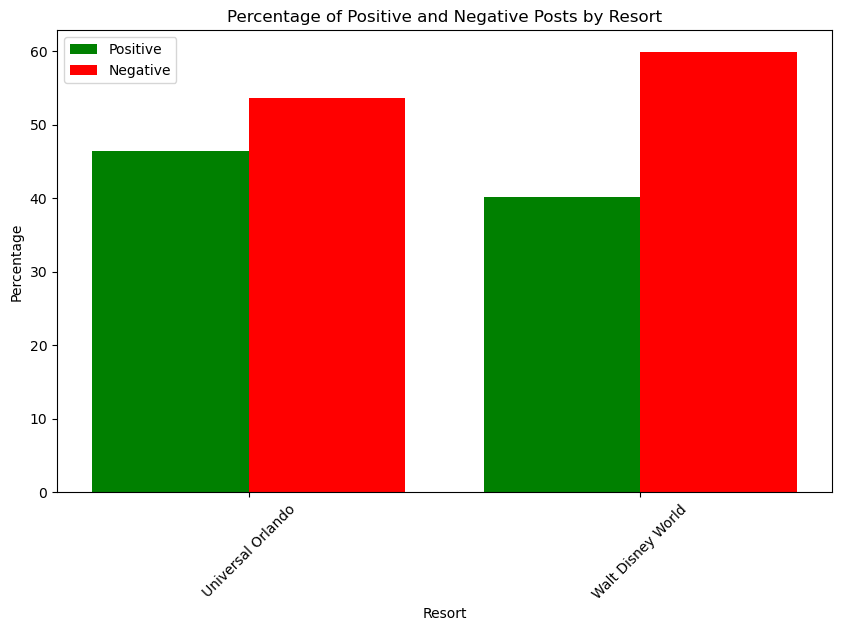

In [78]:
grouped_resort_sentiment_counts = grouped_resort_sentiment_counts.reset_index() #reset the index since the resort was the index col


grouped_resort_sentiment_counts.set_index("Resort", inplace=True) #set it back again? (checking why)


x = np.arange(len(grouped_resort_sentiment_counts)) #arrange it into an  np array based on the length of that df
width = 0.4  #sets the width 


fig, ax = plt.subplots(figsize=(10, 6)) #plot size


bar1 = ax.bar(x - width/2, grouped_resort_sentiment_counts["Percentage Positive"], width, label="Positive", color="green") #bar 1 stats for each resort
bar2 = ax.bar(x + width/2, grouped_resort_sentiment_counts["Percentage Negative"], width, label="Negative", color="red") #bar 2 stats for each resort


ax.set_xlabel("Resort") 
ax.set_ylabel("Percentage")
ax.set_title("Percentage of Positive and Negative Posts by Resort") #labels
ax.set_xticks(x) #middle ticks in between cols?
ax.set_xticklabels(grouped_resort_sentiment_counts.index, rotation=45) #rotate labels
ax.legend() #display legend


Resort_Review_Bar = plt.show() #assign it

Resort_Review_Bar #call it

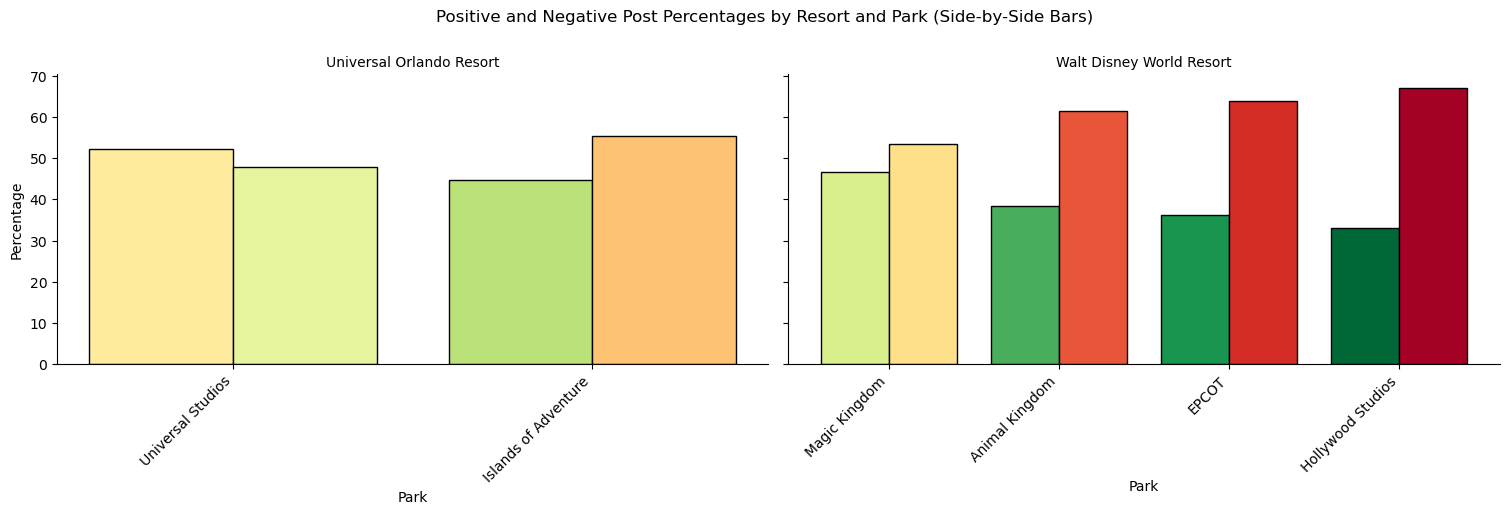

In [79]:
#Graph 2 Percentage of Positive and Negative Reviews By Park

grouped_park_sentiment_counts = grouped_park_sentiment_counts.reset_index() #reset the index of the df if the col was the index col

melted_df = grouped_park_sentiment_counts.melt( #melt vars together
    id_vars=["Resort", "Park"], #x's
    value_vars=["Percentage Positive", "Percentage Negative"], #values
    var_name="Sentiment Type", #labels
    value_name="Percentage") #labels

cmap = sns.color_palette("RdYlGn_r", as_cmap=True)  #color mapping heat scaled warmer is worse and greener is better

min_val, max_val = melted_df["Percentage"].min(), melted_df["Percentage"].max() #take the min and max of each percentage value
melted_df["Color"] = melted_df.apply( #apply the color scale to the values
    lambda row: cmap((row["Percentage"] - min_val) / (max_val - min_val)), axis=1) #map colors to values

width = 0.4  #wdidth of bar

g = sns.FacetGrid(melted_df, col="Resort", sharex=False, sharey=True, height=5, aspect=1.5) #graph for each side of trellis

def barplot(data, **kwargs): #create a function for each graph
    ax = plt.gca() #2 gca plots
    
    parks = data["Park"].unique() #X var
    x = np.arange(len(parks)) #sort it by length of x's

    pos_values = data[data["Sentiment Type"] == "Percentage Positive"].set_index("Park").reindex(parks) #create positive and negative value indexes
    neg_values = data[data["Sentiment Type"] == "Percentage Negative"].set_index("Park").reindex(parks) 

    pos_values["Percentage"].fillna(0, inplace=True) #fill those indexes with 0's for each na if they have any na's 
    neg_values["Percentage"].fillna(0, inplace=True)

    ax.bar(x - width/2, pos_values["Percentage"], width, color=pos_values["Color"], label="Positive", edgecolor="black") #bar width and color set by values
    ax.bar(x + width/2, neg_values["Percentage"], width, color=neg_values["Color"], label="Negative", edgecolor="black")

    ax.set_xticks(x) #tick marks in between bars
    ax.set_xticklabels(parks, rotation=45, ha="right") #rotate labels
    ax.legend() #display legend

g.map_dataframe(barplot) #call the type of plot to use

g.set_axis_labels("Park", "Percentage") #labels 
g.set_titles(col_template="{col_name} Resort") #fancy print title of your parks into resort names
plt.subplots_adjust(top=0.85) #adjust height
g.fig.suptitle("Positive and Negative Post Percentages by Resort and Park (Side-by-Side Bars)") #title

Park_Review_Bar = plt.show() #assign it

Park_Review_Bar #call it

In [80]:
grouped_ride_types_sentiment_counts #just the next df I'll use

Sentiment,NEGATIVE,POSITIVE,Percentage Positive,Percentage Negative
Ride Type,,,,
Moving Carpet,1,5,83.33,16.67
Teacups,2,5,71.43,28.57
Carousel,7,8,53.33,46.67
Flight Simulator,12,13,52.00,48.00
Dark,165,136,45.18,54.82
Coaster,162,115,41.52,58.48
Water,13,9,40.91,59.09
3-D Film Attraction,9,6,40.00,60.00
Drop Tower,18,11,37.93,62.07


In [81]:
grouped_ride_types_sentiment_counts["Percentage Positive"] #list out labels 

Ride Type
Moving Carpet          83.33
Teacups                71.43
Carousel               53.33
Flight Simulator       52.00
Dark                   45.18
Coaster                41.52
Water                  40.91
3-D Film Attraction    40.00
Drop Tower             37.93
Riverboat              36.84
Motion Simulator       36.11
Race Car               28.57
Guided Tour            25.00
Train                  10.53
Name: Percentage Positive, dtype: float64

In [82]:
#Taking care of Guided Tours being 0.....we can't show color scale with 0 values apparently 
grouped_ride_types_sentiment_counts.loc["Guided Tour", "Percentage Positive"] += 0.01 #we can't work with 0's so give all 0's here a small bump 

grouped_ride_types_sentiment_counts.loc["Guided Tour", "Percentage Positive"] #display those vals after the bump to make sure it worked

25.01

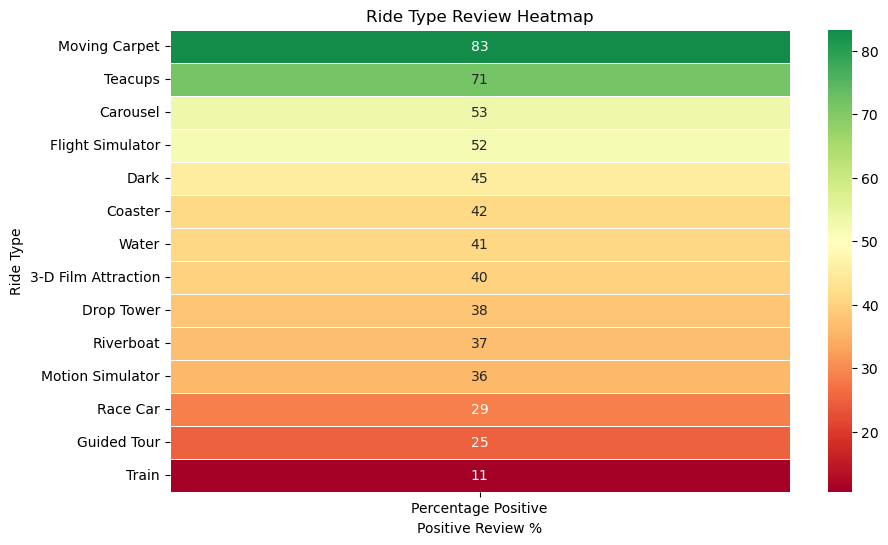

In [83]:
#Visual 3 Graphing out Ride Type as a Whole between both Resorts

plt.figure(figsize=(10, 6)) #plot size metrics
sns.heatmap( #use a heat map to display review values
    grouped_ride_types_sentiment_counts[["Percentage Positive"]], #data is per positive
    annot=True, #include annotations
    cmap="RdYlGn", #color scale green is better, red is worse
    center=50, #make 50 the midpoint for neutral tones
    linewidths=0.5) #size for bars


plt.title("Ride Type Review Heatmap")
plt.xlabel("Positive Review %") #labels
plt.ylabel("Ride Type")


Ride_Types_Heatmap = plt.show() #assign it

Ride_Types_Heatmap #call it

In [84]:
top_ride_types

Sentiment                           NEGATIVE  POSITIVE  Percentage Positive  \
Resort            Ride Type                                                   
Universal Orlando Moving Carpet          1.0       5.0                83.33   
                  Drop Tower             1.0       4.0                80.00   
                  Teacups                1.0       1.0                50.00   
Walt Disney World Teacups                1.0       4.0                80.00   
                  Carousel               7.0       8.0                53.33   
                  Flight Simulator      12.0      13.0                52.00   

Sentiment                           Percentage Negative  
Resort            Ride Type                              
Universal Orlando Moving Carpet                   16.67  
                  Drop Tower                      20.00  
                  Teacups                         50.00  
Walt Disney World Teacups                         20.00  
                  Carousel                        46.67  
                  Flight Simulator                48.00

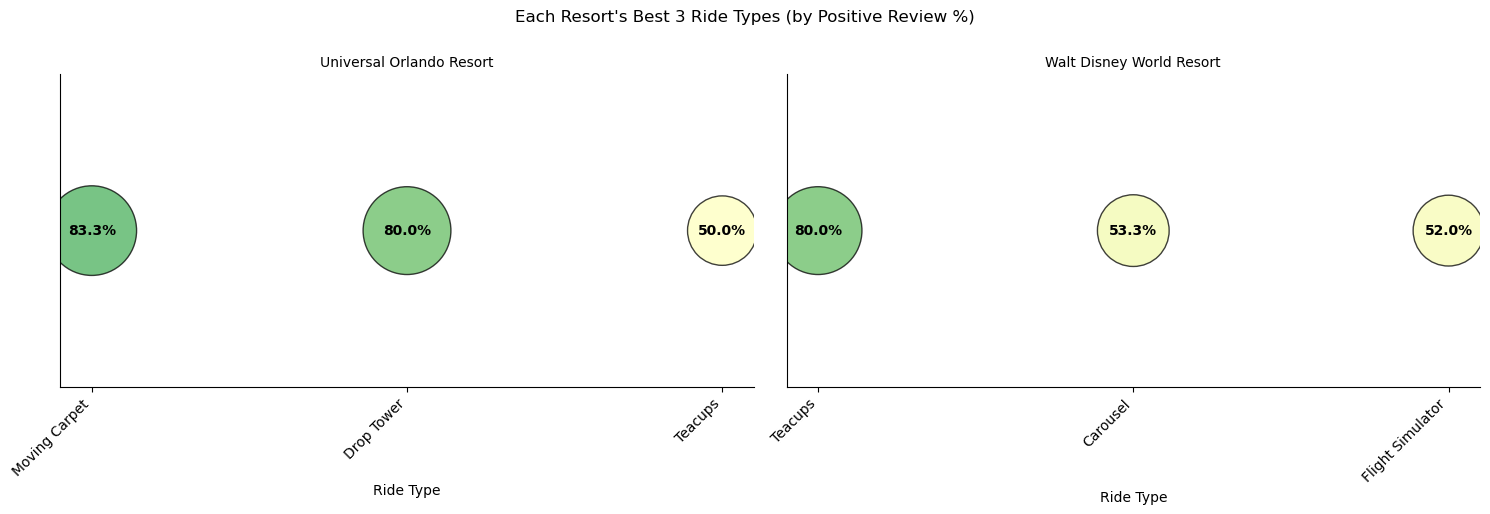

In [85]:
#Creating a Bubble Chart for Top Rides for each Resort
top_ride_types = top_ride_types.reset_index() #reset the index col


g = sns.FacetGrid(top_ride_types, col="Resort", sharex=False, sharey=True, height=5, aspect=1.5) #graph information


def bubble_chart(data, **kwargs): #create a bubble chart for each resort
    ax = plt.gca()
    
    size_factor = 500 #size of bubble
    sizes = data["Percentage Positive"] * size_factor / 10 #make the base size applied to the percentage 
    
    cmap = plt.cm.RdYlGn #again map values to colors
    norm = plt.Normalize(vmin=0, vmax=100) #min/max values 0 to 100
    colors = [cmap(norm(val)) for val in data["Percentage Positive"]] #map colors to percentage positive values
    
    scatter = ax.scatter(data["Ride Type"], [1] * len(data), #spread data out in the graph
                         s=sizes, c=colors, edgecolors="black", alpha=0.75)
    
    for i, row in data.iterrows(): #for each ride typefnacy print the ride type and the per positive out to 1 decimal
        ax.text(row["Ride Type"], 1, f"{row['Percentage Positive']:.1f}%", 
                ha="center", va="center", fontsize=10, weight="bold", color="black") #center bubbles
    
    ax.set_xticklabels(data["Ride Type"], rotation=45, ha="right") #rotate labels
    ax.set_yticks([])  
    
g.map_dataframe(bubble_chart) #assign the bubble chart to each graph

g.set_axis_labels("Ride Type", "") #set labels
g.set_titles(col_template="{col_name} Resort")
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Each Resort's Best 3 Ride Types (by Positive Review %)")

Top_Resort_Rides = plt.show() #assign it

Top_Resort_Rides #call it


In [86]:
worst_ride_types

Sentiment                           NEGATIVE  POSITIVE  Percentage Positive  \
Resort            Ride Type                                                   
Universal Orlando Train                 16.0       2.0                11.11   
                  Water                  8.0       4.0                33.33   
                  Motion Simulator       4.0       2.0                33.33   
Walt Disney World Train                  1.0       0.0                 0.00   
                  Guided Tour            3.0       1.0                25.00   
                  Race Car              10.0       4.0                28.57   

Sentiment                           Percentage Negative  
Resort            Ride Type                              
Universal Orlando Train                           88.89  
                  Water                           66.67  
                  Motion Simulator                66.67  
Walt Disney World Train                          100.00  
                  Guided Tour                     75.00  
                  Race Car                        71.43

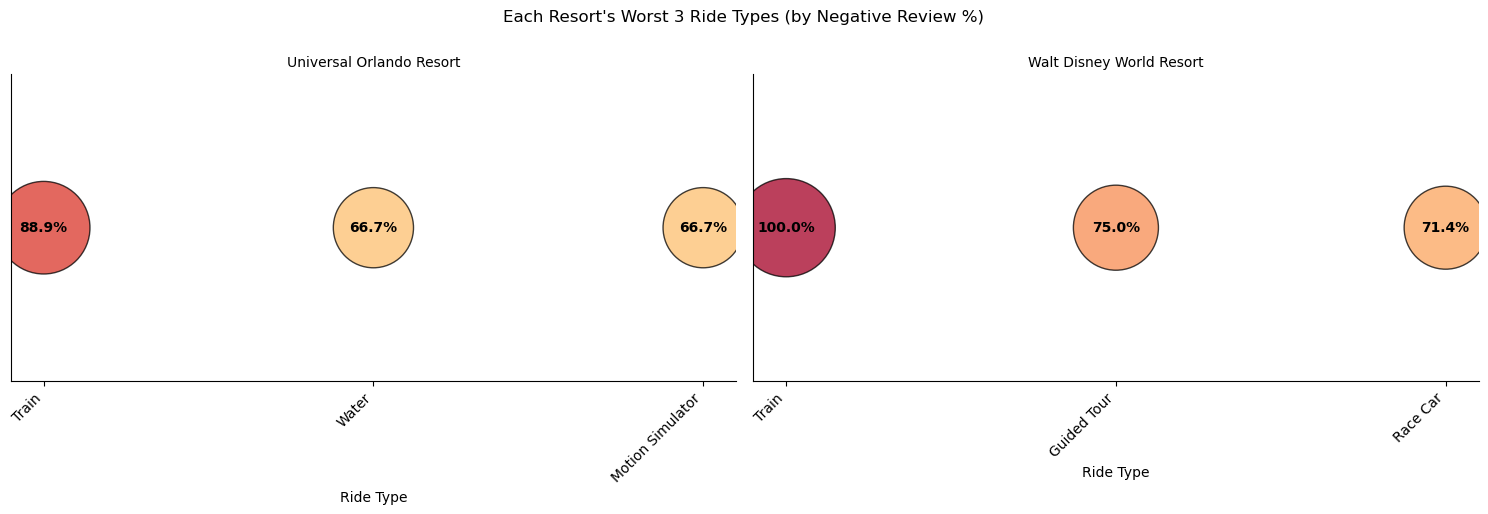

In [87]:
#Visual for the Bubble Chart of each Resort's worst 3 Ride Types
worst_ride_types = worst_ride_types.reset_index() #reset col index 


g = sns.FacetGrid(worst_ride_types, col="Resort", sharex=False, sharey=True, height=5, aspect=1.5) #graph metrics


def bubble_chart(data, **kwargs): #make a function to apply to each bubble chart
    ax = plt.gca() #each plot
    
    size_factor = 500 #base size
    sizes = data["Percentage Negative"] * size_factor / 10 #determine bubble size based on negative vals
    
    cmap = plt.cm.RdYlGn_r #this time reverse colors red is more and green is less since we are looking at negative 
    norm = plt.Normalize(vmin=0, vmax=100) #set a min/max for each color scale
    colors = [cmap(norm(val)) for val in data["Percentage Negative"]] #map colors to per negative vals
    
    scatter = ax.scatter(data["Ride Type"], [1] * len(data), #scatter bubbles/dots
                         s=sizes, c=colors, edgecolors="black", alpha=0.75)
    
    for i, row in data.iterrows(): #for each ride type
        ax.text(row["Ride Type"], 1, f"{row['Percentage Negative']:.1f}%", #fancy print the rides and their per negative vals
                ha="center", va="center", fontsize=10, weight="bold", color="black")
    
    ax.set_xticklabels(data["Ride Type"], rotation=45, ha="right") #rotate labels
    ax.set_yticks([])  
    
g.map_dataframe(bubble_chart) #assign bubble chart to each graph

g.set_axis_labels("Ride Type", "") #set labels
g.set_titles(col_template="{col_name} Resort")
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Each Resort's Worst 3 Ride Types (by Negative Review %)")

Bottom_Resort_Rides = plt.show() #assign it

Bottom_Resort_Rides #call it

In [88]:
grouped_resort_sentiment_score

,Resort,Average Sentiment Score
0,Universal Orlando,-0.088705
1,Walt Disney World,-0.193465


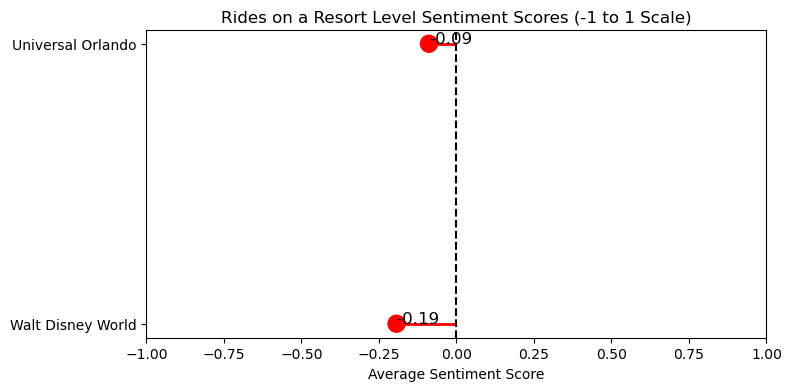

In [89]:
#Visual for overall Resort Sentiment Score

grouped_resort_sentiment_score = grouped_resort_sentiment_score.sort_values("Average Sentiment Score") #sort values desc


colors = ["red" if x < 0 else "green" for x in grouped_resort_sentiment_score["Average Sentiment Score"]] #assign red to values below the 0 midpoint and green to ones above


plt.figure(figsize=(8, 4)) #graph size
plt.hlines(y=grouped_resort_sentiment_score["Resort"], xmin=0, #have a line for each resort
           xmax=grouped_resort_sentiment_score["Average Sentiment Score"], #line for each score
           color=colors, linewidth=2)
plt.scatter(grouped_resort_sentiment_score["Average Sentiment Score"], #dot for each score
            grouped_resort_sentiment_score["Resort"], #have a dot for each resort
            color=colors, s=150)


for index, value in enumerate(grouped_resort_sentiment_score["Average Sentiment Score"]): #for resorts, and values in average scores var
    plt.text(value, index, f"{value:.2f}", ha="left" if value < 0 else "right", fontsize=12, color="black") #give labels to each lollipop point based on their respective vals


plt.axvline(x=0, color="black", linestyle="dashed") #set some graph labels
plt.xlabel("Average Sentiment Score")
plt.ylabel("")
plt.title("Rides on a Resort Level Sentiment Scores (-1 to 1 Scale)")
plt.xlim(-1, 1) #make the scale from -1 to 1
Resort_Overall_Sentiment = plt.show() #assign it

Resort_Overall_Sentiment #call it
    

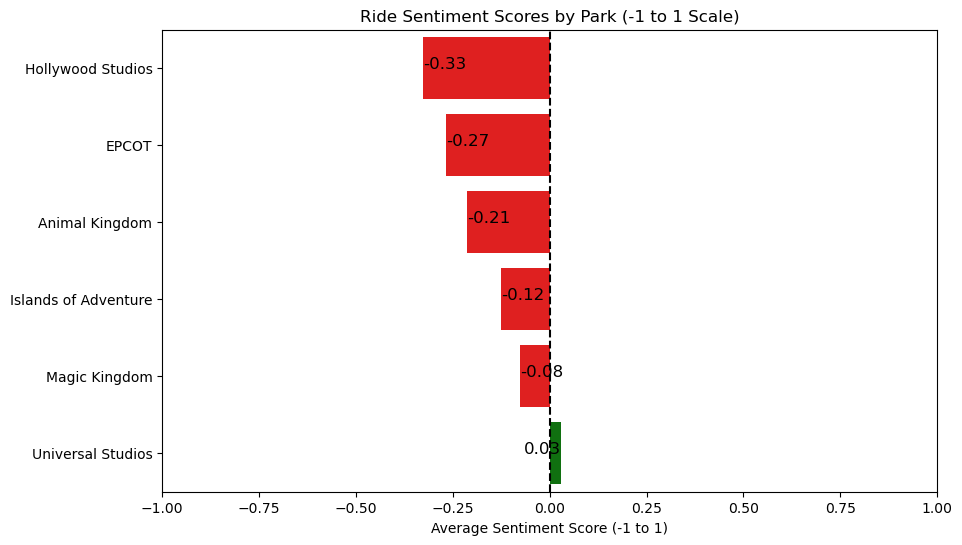

In [90]:
#Visual for Average Ride Sentiment Score by Park

grouped_parks_sentiment_score = grouped_parks_sentiment_score.sort_values("Average Sentiment Score") #sort by av score

colors = ["red" if x < 0 else "green" for x in grouped_parks_sentiment_score["Average Sentiment Score"]] #again if below 0, make the points red if not green

plt.figure(figsize=(10, 6)) #graph sizes
sns.barplot(
    y=grouped_parks_sentiment_score["Park"], #now group by park instead of resort
    x=grouped_parks_sentiment_score["Average Sentiment Score"], 
    palette=colors, 
    orient="h")

for index, value in enumerate(grouped_parks_sentiment_score["Average Sentiment Score"]): #for each park
    plt.text(value, index, f"{value:.2f}", ha="left" if value < 0 else "right", fontsize=12, color="black") #display the text for each park's sent score on the bar

plt.axvline(x=0, color="black", linestyle="dashed") #set labels
plt.xlabel("Average Sentiment Score (-1 to 1)")
plt.ylabel("")
plt.title("Ride Sentiment Scores by Park (-1 to 1 Scale)")
plt.xlim(-1, 1) #-1 to 1 scale again

Ride_Sentiment_Scores_Park = plt.show() #assign it

Ride_Sentiment_Scores_Park #call it


In [91]:
grouped_ride_types_by_resort_sentiment_score

,Resort,Ride Type,Average Sentiment Score
0,Universal Orlando,Coaster,-0.058418
1,Universal Orlando,Dark,-0.053238
2,Universal Orlando,Drop Tower,0.586371
3,Universal Orlando,Motion Simulator,-0.259720
4,Universal Orlando,Moving Carpet,0.624669
5,Universal Orlando,Teacups,0.002998
6,Universal Orlando,Train,-0.745534
7,Universal Orlando,Water,-0.323738
8,Walt Disney World,3-D Film Attraction,-0.174478
9,Walt Disney World,Carousel,0.041480


In [92]:
print(grouped_ride_types_by_resort_sentiment_score[grouped_ride_types_by_resort_sentiment_score["Ride Type"].isin(["Guided Tour", "Race Car"])]) #these two rides had val issues

               Resort    Ride Type  Average Sentiment Score
14  Walt Disney World  Guided Tour                -0.456210
16  Walt Disney World     Race Car                -0.412298



Plotting data for Universal Orlando
          Ride Type  Average Sentiment Score
6             Train                -0.745534
7             Water                -0.323738
3  Motion Simulator                -0.259720
0           Coaster                -0.058418
1              Dark                -0.053238
5           Teacups                 0.002998
2        Drop Tower                 0.586371
4     Moving Carpet                 0.624669

Plotting data for Walt Disney World
              Ride Type  Average Sentiment Score
19                Train                -0.959255
14          Guided Tour                -0.456210
16             Race Car                -0.412298
12           Drop Tower                -0.406199
10              Coaster                -0.333342
17            Riverboat                -0.278362
15     Motion Simulator                -0.276609
8   3-D Film Attraction                -0.174478
11                 Dark                -0.121592
20                Water        

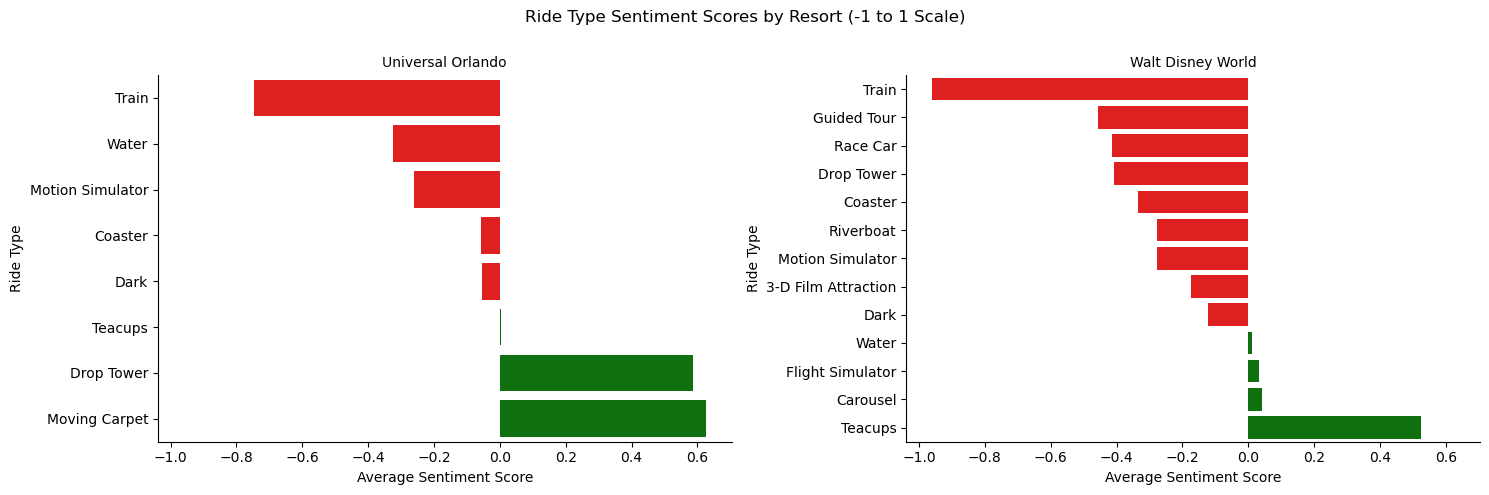

In [93]:
#Plotting out Ride Types and their respective sentiment scores for each resort
grouped_ride_types_by_resort_sentiment_score = grouped_ride_types_by_resort_sentiment_score.sort_values(
    ["Resort", "Average Sentiment Score"]) #group ride type scores by resort


g = sns.FacetGrid(grouped_ride_types_by_resort_sentiment_score, col="Resort", sharex=True, sharey=False, height=5, aspect=1.5) #graph metrics

def diverging_bar_chart(data, **kwargs): #create a function to make a diverging bar chart
    ax = plt.gca()
    
    
    print(f"\nPlotting data for {data['Resort'].unique()[0]}") #I had an issue where it was grouping some rides in disney and pulling them over to universal
    print(data[["Ride Type", "Average Sentiment Score"]]) #print out the data beforehand to verify
    
    data = data.sort_values("Average Sentiment Score") #use the SA score vals
    colors = ["red" if x < 0 else "green" for x in data["Average Sentiment Score"]] #again red is below 0 and green is above
    sns.barplot(y=data["Ride Type"], x=data["Average Sentiment Score"], palette=colors, orient="h", ax=ax) #make a barplot based on those vals

g.map_dataframe(diverging_bar_chart) #assign the bar plot to each graph


g.set_titles(col_template="{col_name}") #set labels
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Ride Type Sentiment Scores by Resort (-1 to 1 Scale)")


Ride_Sentiment_By_Resort_and_Type = plt.show() #assign it

Ride_Sentiment_By_Resort_and_Type #call it


In [94]:
grouped_ride_types_by_park_sentiment_score

,Resort,Park,Ride Type,Average Sentiment Score
0,Universal Orlando,Islands of Adventure,Coaster,-0.071914
1,Universal Orlando,Islands of Adventure,Dark,-0.072179
2,Universal Orlando,Islands of Adventure,Drop Tower,0.586371
3,Universal Orlando,Islands of Adventure,Train,-0.745534
4,Universal Orlando,Islands of Adventure,Water,-0.323738
5,Universal Orlando,Universal Studios,Coaster,0.030270
6,Universal Orlando,Universal Studios,Dark,-0.024827
7,Universal Orlando,Universal Studios,Motion Simulator,-0.259720
8,Universal Orlando,Universal Studios,Moving Carpet,0.624669
9,Universal Orlando,Universal Studios,Teacups,0.002998



Plotting data for Islands of Adventure
    Ride Type  Average Sentiment Score
0     Coaster                -0.071914
1        Dark                -0.072179
2  Drop Tower                 0.586371
3       Train                -0.745534
4       Water                -0.323738

Plotting data for Universal Studios
          Ride Type  Average Sentiment Score
5           Coaster                 0.030270
6              Dark                -0.024827
7  Motion Simulator                -0.259720
8     Moving Carpet                 0.624669
9           Teacups                 0.002998

Plotting data for Animal Kingdom
              Ride Type  Average Sentiment Score
10  3-D Film Attraction                -0.174478
11              Coaster                -0.302789
12                 Dark                -0.245904
13     Flight Simulator                 0.031837
14          Guided Tour                -0.456210
15                Water                -0.902622

Plotting data for EPCOT
           Ride T

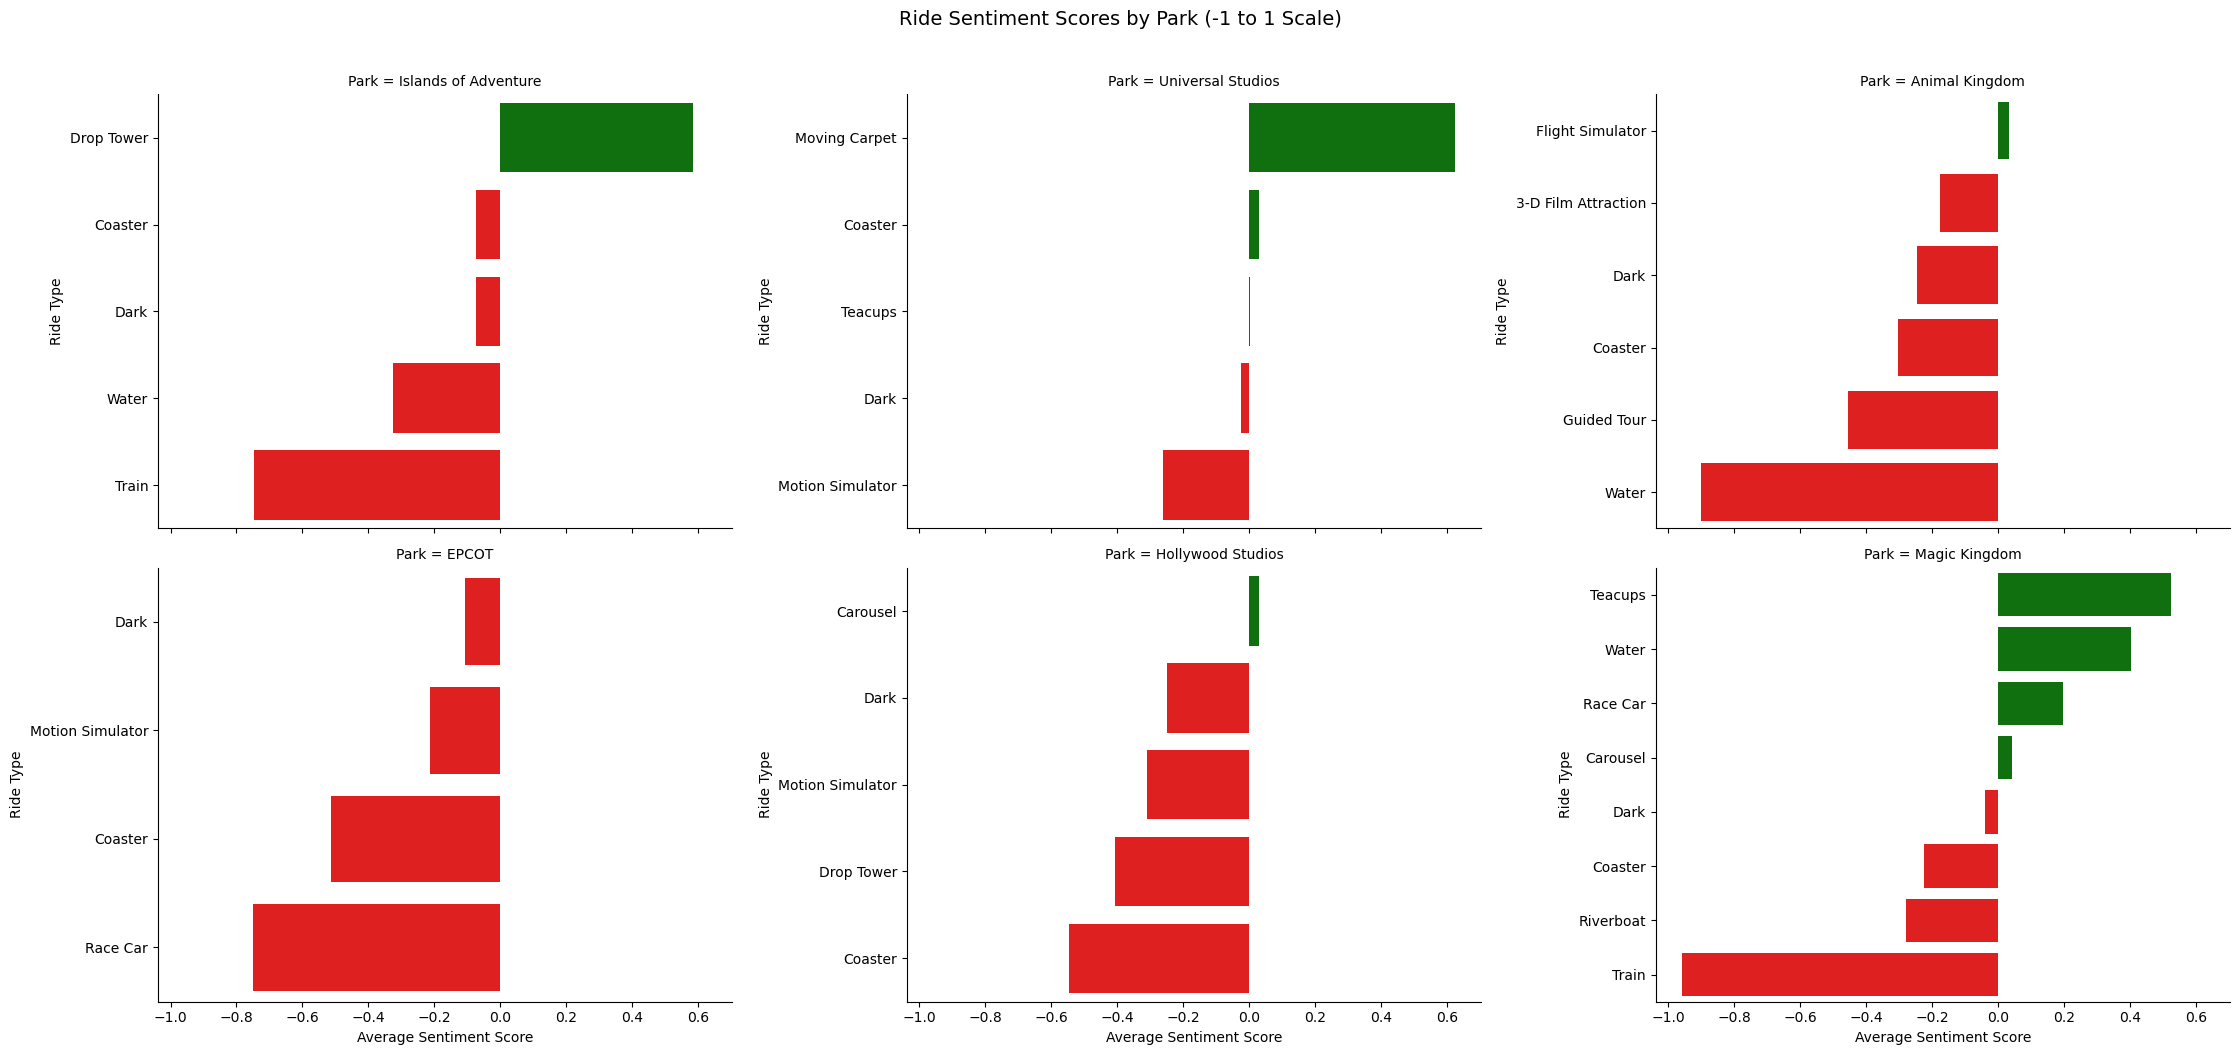

In [164]:
#Last Visual I promise. Now that we've broken out by resort and ride with Sentiment Scores, Let's do the same thing and maybe 
#make 4 graphs to break out ride sentiment scores by park
grouped_ride_types_by_park_sentiment_score["Park"] = grouped_ride_types_by_park_sentiment_score["Park"].str.strip()

g = sns.FacetGrid(
    grouped_ride_types_by_park_sentiment_score, 
    col="Park", col_wrap=3, height=5, aspect=1.5, sharex=True, sharey=False) #Don't share ride types across parks because they're different

def diverging_bar_chart(data, **kwargs):
    ax = plt.gca()
    
    print(f"\nPlotting data for {data['Park'].unique()[0]}")  #Print out's ahead of time before graphing for consistency
    print(data[["Ride Type", "Average Sentiment Score"]])  
    
    data = data.sort_values("Average Sentiment Score") #Oder by score
    colors = ["red" if x < 0 else "green" for x in data["Average Sentiment Score"]] #keep the same color scheme
    
    sns.barplot(
        y=data["Ride Type"], x=data["Average Sentiment Score"], #barplot params
        palette=colors, orient="h", ax=ax)  
    
    ax.set_ylim(-0.5, len(data) - 0.5) #make graphs unique in size to their data

g.map_dataframe(diverging_bar_chart)  #assign the chart type

g.fig.suptitle("Ride Sentiment Scores by Park (-1 to 1 Scale)", fontsize=14, y=1.05)  #labels

Ride_Sentiment_Scores_Park = plt.show() #assign it

Ride_Sentiment_Scores_Park #call it


In [96]:
#Apply our DeepSeek function to the posts
#universal_df["identified_rides"] = universal_df.apply(lambda row: deepseek_analyze(row["title"] + " " + row["selftext"], row.name), axis=1)

#Make sure each ride has a unique row in the dataframe
#universal_df = universal_df.explode("identified_rides").reset_index(drop=True)

#print("\nDataFrame after DeepSeek Analysis and Expansion:")
#print(universal_df.head(10))
